In [1]:
import os
import glob
import yaml

import numpy as np
import pandas as pd
import polars as pl
import pyranges as pr
import pyfaidx
import scipy
import torch
from torch.utils.data import DataLoader, Dataset
import tqdm
import anndata as ad
import pyranges
import plotnine as p9

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve


from enformer_pytorch.data import GenomeIntervalDataset, str_to_one_hot
pd.options.mode.chained_assignment = None 


tqdm.tqdm.pandas()
#from scooby.utils.transcriptome import Transcriptome

In [2]:
base_path = '/s/project/multispecies/Modelling/Snoopy'

In [3]:
gtf_file = f'{base_path}/Data/gencode.v32.annotation.sorted.gtf.gz'
gtf_file_hg19 = f'{base_path}/Data/gencode.v47lift37.annotation.gtf.gz'
bed_file_tsscentred = f'{base_path}/Data/genes_tsscentred.bed'
bed_file_tsscentred_hg19 = f'{base_path}/Data/genes_tsscentred_hg19.bed'
cage_gtf = f'{base_path}/Data/gencode.v32.annotation.sorted.cage.gtf'
fasta_file = f'{base_path}/Data/genome_human.fa'
fasta_file_hg19 = f'{base_path}/Data/genome_human_hg19.fa'
targets_path = f'{base_path}/Data/targets.txt'

# Code

In [73]:
def get_classification_metrics_local(all_vars, all_vars_agg, extra_preds, extra_models):
    rows = []
    for tissue in set(all_vars['tissue']):
        for model in tqdm.tqdm(['borzoi']+extra_models):
            if model in extra_models:
                sub_df = extra_preds.query('tissue == @tissue and model == @model')
                rows.append({
                    "model":"_".join(model.split('.')[1:3]),
                    "method":model.split('.')[-1],
                    'replicate':0,
                    'tissue':tissue,
                    'auroc':roc_auc_score(sub_df['obs.label'] == 1,np.abs(sub_df['pred_effect'])),
                    'auprc':average_precision_score(sub_df['obs.label'] == 1,np.abs(sub_df['pred_effect'])),
                    'n':len(sub_df),
                    'class_balance':(sub_df['obs.label']==1).sum()/len(sub_df),
                })  
                continue
            for rep in [0,1,2,3,'ensemble']:
                for method in set(all_vars['method']):
                    if rep == 'ensemble':
                        sub_df = all_vars_agg.query('tissue == @tissue and model == @model and method == @method')
                    else:
                        sub_df = all_vars.query('tissue == @tissue and model == @model and rep == @rep and method == @method')
                    rows.append({
                        "model":model,
                        "method":method,
                        'replicate':rep,
                        'tissue':tissue,
                        'auroc':roc_auc_score(sub_df['obs.label'] == 1,np.abs(sub_df['pred_effect'])),
                        'auprc':average_precision_score(sub_df['obs.label'] == 1,np.abs(sub_df['pred_effect'])),
                        'n':len(sub_df),
                        'class_balance':(sub_df['obs.label']==1).sum()/len(sub_df),
                    })  
    return pd.DataFrame(rows)


def get_corr_metrics_local(all_vars, all_vars_agg_pos, extra_preds, extra_models, obs_name, switch_refalt=False):
    rows = []
    for tissue in set(all_vars['tissue']):
        for model in tqdm.tqdm(['borzoi']+extra_models):
            if model in extra_models:
                sub_df = extra_preds.loc[extra_preds['obs.label'] == 1].query('tissue == @tissue and model == @model')
                rows.append({
                    "model":"_".join(model.split('.')[1:3]),
                    "method":model.split('.')[-1],
                    'replicate':0,
                    'tissue':tissue,
                    'r':scipy.stats.pearsonr(sub_df[obs_name],sub_df['pred_effect'])[0],
                    'sign_concord':((sub_df[obs_name] > 0) == (sub_df['pred_effect'] > 0)).sum()/len(sub_df),
                    'rho':scipy.stats.spearmanr(sub_df[obs_name],sub_df['pred_effect'])[0],
                    'n':len(sub_df)
                })  
                continue
            for rep in [0,1,2,3,'ensemble']:
                for method in set(all_vars['method']):
                    if rep == 'ensemble':
                        sub_df = all_vars_agg_pos.query('tissue == @tissue and model == @model and method == @method')
                    else:
                        sub_df = all_vars.loc[all_vars['obs.label'] == 1].query('tissue == @tissue and model == @model and rep == @rep and method == @method')
                    # account for ref allele switching
                    sub_df['pred_effect'] = sub_df.apply(lambda x: x['pred_effect'] if x['Ref_allele'] == 'var.allele1' else -x['pred_effect'],axis=1)
                    if switch_refalt:
                        sub_df['pred_effect'] = -1*sub_df['pred_effect']
                    rows.append({
                        "model":model,
                        "method":method,
                        'replicate':rep,
                        'tissue':tissue,
                        'r':scipy.stats.pearsonr(sub_df[obs_name],sub_df['pred_effect'])[0],
                        'sign_concord':((sub_df[obs_name] > 0) == (sub_df['pred_effect'] > 0)).sum()/len(sub_df),
                        'rho':scipy.stats.spearmanr(sub_df[obs_name],sub_df['pred_effect'])[0],
                        'n':len(sub_df)
                    })  
    return pd.DataFrame(rows)

def get_signed_logL2(all_vars):
    all_vars = all_vars.sort_values(['model','rep','method','variant']).reset_index(drop=True)
    all_vars_logL2 = all_vars.query('method == "logL2"')
    all_vars_logL2['pred_effect'] = all_vars_logL2['pred_effect']*np.sign(np.array(all_vars.query('method == "logFC"')['pred_effect']))
    all_vars_logL2['method'] = 'signed_logL2'
    all_vars = pd.concat([all_vars,all_vars_logL2]).reset_index(drop=True)
    return all_vars

def compute_pred_corr(all_vars_agg, chrombpnet_preds, other_model, abs_corr = True, switch_refalt = False):
    chrombpnet_preds = chrombpnet_preds.query('model == @other_model')
    merged = (all_vars_agg[['variant','pred_effect','Ref_allele']]
                  .merge(chrombpnet_preds[['variant','pred_effect']],on=['variant'], suffixes=('','_y')))
    if abs_corr:
        r = scipy.stats.pearsonr(np.abs(merged['pred_effect']),np.abs(merged['pred_effect_y']))[0]
        rho = scipy.stats.spearmanr(np.abs(merged['pred_effect']),np.abs(merged['pred_effect_y']))[0]
    else:
        merged['pred_effect'] = merged.apply(lambda x: x['pred_effect'] if x['Ref_allele'] == 'var.allele1' else -x['pred_effect'],axis=1)
        if switch_refalt:
            merged['pred_effect'] = -1*merged['pred_effect']
        r = scipy.stats.pearsonr(merged['pred_effect'],merged['pred_effect_y'])[0]
        rho = scipy.stats.spearmanr(merged['pred_effect'],merged['pred_effect_y'])[0]
    return (r, rho)

# dsQTL

In [45]:
variants_df = pd.read_table("Data/chrombpnet/dsqtls.yoruba.lcls.benchmarking.all.tsv")

In [46]:
variants_df = variants_df.loc[variants_df['var.isused']].rename(columns={'var.chr':'Chromosome','var.pos_hg19':'Pos'})

In [47]:
variants_df['End'] = variants_df['Pos']
variants_df['Start'] = variants_df['Pos'] - 1

# assign ref and alt
fasta = pyfaidx.Fasta(fasta_file_hg19)
check = variants_df.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper() in [x['var.allele1'],x['var.allele2']],axis=1)
assert check.sum() == len(check)
variants_df['Ref'] = variants_df.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper(),axis=1)



00%|██████████| 27373/27373 [00:00<00:00, 35365.87it/s]

In [48]:
variants_df['Alt'] = variants_df.progress_apply(lambda x: x['var.allele1'] if x['var.allele2'] == x['Ref'] else x['var.allele2'] ,axis=1)


00%|██████████| 27373/27373 [00:00<00:00, 111111.77it/s]

In [49]:
variants_df['variant'] = variants_df['Chromosome'] + "_" + variants_df['Start'].astype('str') + "_" + variants_df['Alt']

In [50]:
variants_df['Ref_allele'] = variants_df.progress_apply(lambda x: 'var.allele2' if x['var.allele2'] == x['Ref'] else 'var.allele1',axis=1)


00%|██████████| 27373/27373 [00:00<00:00, 127909.94it/s]

In [51]:
variants_df[['Chromosome','Start','End','Ref', 'Alt','variant']].to_csv('Data/chrombpnet/dsqtls.yoruba.lcls.benchmarking.all.all_vars.tsv',sep="\t",index=None)

In [52]:
variants_df.to_csv('Data/chrombpnet/dsqtls.yoruba.lcls.benchmarking.all.renamed.tsv',sep="\t",index=None)

In [53]:
variants_df['tissue'] = 'GM12878'

In [54]:
variants_df['Ref_allele'].value_counts()

Ref_allele
var.allele2    22085
var.allele1     5288
Name: count, dtype: int64

## Write config

In [12]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_dsqtlhg19_keepscale_logL2_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_dsqtlhg19_keepscale_logL2_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/chrombpnet/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/chrombpnet/dsqtls.yoruba.lcls.benchmarking.all.all_vars.tsv',
                  'fasta_file': fasta_file_hg19,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'prediction_bin_mode': 32,
                  'track_subset': 'DNASE',
                  'metric': 'logL2',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

In [13]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_dsqtlhg19_keepscale_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_dsqtlhg19_keepscale_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/chrombpnet/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/chrombpnet/dsqtls.yoruba.lcls.benchmarking.all.all_vars.tsv',
                  'fasta_file': fasta_file_hg19,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'prediction_bin_mode': 32,
                  'track_subset': 'DNASE',
                  'metric': 'logfc',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run

In [116]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
Pipe/Configs/borzoi_dsqtlhg19_keepscale_logL2_3.txt \
doing_stuff_in_the_arena \
Pipe/job_reports/

Submitted batch job 16611842


In [54]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
Pipe/Configs/flashzoi_dsqtlhg19_keepscale_3.txt \
doing_stuff_in_the_arena \
Pipe/job_reports/

Submitted batch job 16579777


## Map Borzoi tracks

In [55]:
def make_borzoi_mapping(adata):
    mapping = {
         'GM12878':['DNASE:GM12878'],
    }
    return mapping

## Load predictions

In [56]:
rows = []
df_list = []
mapping = None
for model in ['borzoi']:
    for method in ['logL2','logFC']:
        for rep in tqdm.tqdm([0,1,2,3]):
            adata_list = []

            method_string = "" if method == "logFC" else "_"+method
            paths = sorted(glob.glob(f'Results/chrombpnet/Chunky/{model}_dsqtlhg19_keepscale{method_string}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if mapping is None:
                    mapping = make_borzoi_mapping(adata)
                mapping = mapping
                adata.obs_names = adata.obs['variant']
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            
            for tissue in mapping.keys():
                reduced_df = variants_df.query('tissue == @tissue')
                assert len(reduced_df) > 0
            
                reduced_adata = adata[adata.obs.index.isin(set(reduced_df['variant'])), adata.var.description.isin(mapping[tissue])]
                snp_effects = pd.DataFrame({'variant':reduced_adata.obs_names,
                                            #'pred_effect':reduced_adata.X.mean(axis=1)})
                                            'pred_effect':reduced_adata.X[:,0]})# Dr Nair only uses first DNASE track
                snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                
                reduced_df = reduced_df.merge(snp_effects, on=['variant'])
                assert len(reduced_df) == len(snp_effects)

                reduced_df['method'] = method
                reduced_df['model'] = model
                reduced_df['rep'] = rep
                df_list.append(reduced_df)

all_vars = pd.concat(df_list)



00%|██████████| 4/4 [00:09<00:00,  2.34s/it]

In [57]:
for rep in [0,1,2,3]:
    for method in ['logL2','logFC']:
        assert len(all_vars.query('model == "borzoi" and rep == @rep and method == @method')) == len(variants_df)

In [58]:
all_vars = get_signed_logL2(all_vars)

## Analyze 

In [59]:
chrombpnet_models = [x for x in all_vars.columns if 'chrombpnet' in x or 'gkm' in x or 'enformer' in x]
chrombpnet_preds = all_vars.query('model == "borzoi" and rep == 0 and method == "logFC"')[['variant','tissue','obs.label','obs.estimate']+chrombpnet_models].melt(id_vars=['variant','tissue','obs.label','obs.estimate'],var_name='model',value_name='pred_effect')
assert len(chrombpnet_preds['variant'].drop_duplicates()) == len(variants_df)

In [60]:
all_vars_agg = all_vars.groupby(['variant','method','tissue','model','Ref_allele','obs.label'],observed=True)['pred_effect'].mean().reset_index()

In [62]:
chrombpnet_preds

,variant,tissue,obs.label,obs.estimate,model,pred_effect
0,chr10_100012010_T,GM12878,-1,NaN,pred.gkmsvm.encsr000emt.varscore.deltasvm,-1.474374
1,chr10_100025815_A,GM12878,-1,NaN,pred.gkmsvm.encsr000emt.varscore.deltasvm,-2.614721
2,chr10_100057706_T,GM12878,-1,NaN,pred.gkmsvm.encsr000emt.varscore.deltasvm,2.609053
3,chr10_100071683_A,GM12878,-1,NaN,pred.gkmsvm.encsr000emt.varscore.deltasvm,-2.036113
4,chr10_100121077_T,GM12878,-1,NaN,pred.gkmsvm.encsr000emt.varscore.deltasvm,-0.332156
...,...,...,...,...,...,...
1012796,chr9_99639552_G,GM12878,-1,NaN,pred.chrombpnet.encsr637xsc_5m.varscore.ips,0.000257
1012797,chr9_99801280_C,GM12878,-1,NaN,pred.chrombpnet.encsr637xsc_5m.varscore.ips,0.000046
1012798,chr9_99826118_A,GM12878,-1,NaN,pred.chrombpnet.encsr637xsc_5m.varscore.ips,0.000015
1012799,chr9_99826119_T,GM12878,-1,NaN,pred.chrombpnet.encsr637xsc_5m.varscore.ips,0.000013


In [76]:
compute_pred_corr(all_vars_agg, chrombpnet_preds, "pred.chrombpnet.encsr637xsc.varscore.ips", abs_corr = True, switch_refalt = True)

(0.6857683201755576, 0.5521643974111188)

In [146]:
dsqtl_metric_df = get_classification_metrics_local(all_vars, all_vars_agg, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models)
dsqtl_metric_df.query('method != "signed_logL2"').sort_values('auprc',ascending=False).head(20)


00%|██████████| 38/38 [00:02<00:00, 12.86it/s]

,model,method,replicate,tissue,auroc,auprc,n,class_balance
14,borzoi,logL2,ensemble,GM12878,0.963648,0.637414,27373,0.020458
5,borzoi,logL2,1,GM12878,0.958668,0.622089,27373,0.020458
11,borzoi,logL2,3,GM12878,0.956150,0.609301,27373,0.020458
8,borzoi,logL2,2,GM12878,0.953202,0.602423,27373,0.020458
2,borzoi,logL2,0,GM12878,0.957085,0.599408,27373,0.020458
12,borzoi,logFC,ensemble,GM12878,0.945534,0.591344,27373,0.020458
3,borzoi,logFC,1,GM12878,0.944010,0.580492,27373,0.020458
6,borzoi,logFC,2,GM12878,0.941428,0.567489,27373,0.020458
9,borzoi,logFC,3,GM12878,0.942887,0.566137,27373,0.020458
0,borzoi,logFC,0,GM12878,0.939117,0.554213,27373,0.020458


In [77]:
all_vars_agg_pos = all_vars.loc[all_vars['obs.label'] == 1].groupby(['variant','Ref_allele','method','tissue','model','obs.estimate'],observed=True)['pred_effect'].mean().reset_index()

In [79]:
compute_pred_corr(all_vars_agg_pos, chrombpnet_preds, "pred.chrombpnet.encsr637xsc.varscore.logfc", abs_corr = False, switch_refalt = True)

(0.48872400889406736, 0.562625797082848)

In [78]:
dsqtl_corr_df = get_corr_metrics_local(all_vars, all_vars_agg_pos, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models, obs_name='obs.estimate', switch_refalt=True)
dsqtl_corr_df.sort_values('r',ascending=False).head(20)


00%|██████████| 38/38 [00:00<00:00, 80.11it/s] 

,model,method,replicate,tissue,r,sign_concord,rho,n
14,borzoi,signed_logL2,ensemble,GM12878,0.782578,0.930357,0.787632,560
11,borzoi,signed_logL2,3,GM12878,0.777558,0.939286,0.781238,560
5,borzoi,signed_logL2,1,GM12878,0.773220,0.928571,0.786838,560
2,borzoi,signed_logL2,0,GM12878,0.770270,0.926786,0.781930,560
8,borzoi,signed_logL2,2,GM12878,0.762275,0.939286,0.777750,560
12,borzoi,logFC,ensemble,GM12878,0.761539,0.932143,0.785015,560
26,chrombpnet_encsr637xsc,logfc,0,GM12878,0.758618,0.930357,0.783086,560
20,chrombpnet_encsr000emt,jsd,0,GM12878,0.757596,0.910714,0.776770,560
9,borzoi,logFC,3,GM12878,0.757122,0.939286,0.780482,560
36,chrombpnet_encsr637xsc_100m,logfc,0,GM12878,0.754667,0.925000,0.777268,560


In [169]:
borzoi_ensembl_rank = all_vars_agg.query('method == "logFC"')[['variant','model','pred_effect','obs.label']]
borzoi_ensembl_rank['model'] = "Borzoi (Ensemble)"
borzoi_rep0_rank = all_vars.query('method == "logFC" and rep == 0')[['variant','model','pred_effect','obs.label']]
borzoi_rep0_rank['model'] = "Borzoi (Rep 0)"
borzoi_rank = pd.concat([borzoi_ensembl_rank,borzoi_rep0_rank])
chrombpnet_rank = chrombpnet_preds[['variant','model','pred_effect','obs.label']].query('model in ["pred.chrombpnet.encsr637xsc.varscore.ips","pred.chrombpnet.encsr000emt.varscore.ips"]')
chrombpnet_rank['model'] = chrombpnet_rank["model"].apply(lambda x: "Chrombpnet (Best)" if x == "pred.chrombpnet.encsr637xsc.varscore.ips" else "Chrombpnet (Matched)")
rank = pd.concat([borzoi_rank,chrombpnet_rank])

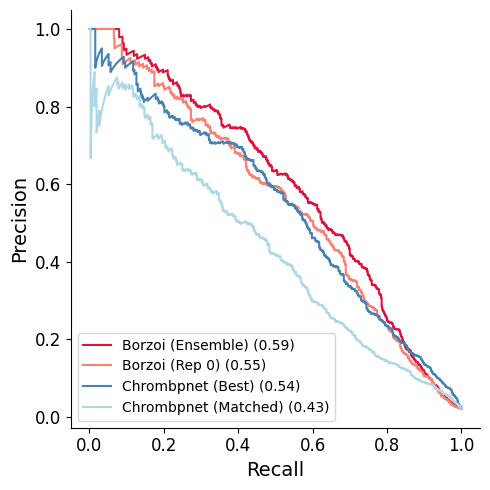

In [194]:
ap_plot_df_list = []
ap_dict = {}
import matplotlib.pyplot as plt


for pred_type in set(rank['model']):
    sub_df = rank.query('model == @pred_type')
    labels = np.array(sub_df['obs.label'])
    pred = np.array(np.abs(sub_df['pred_effect']))
    precision, recall, thresholds = precision_recall_curve(y_true=labels, probas_pred=pred)
    ap = average_precision_score(y_true=labels, y_score=pred)
    ap_dict[pred_type] = ap
    ap_plot_df_list.append(pd.DataFrame({"precision":precision,"recall":recall,"ap":ap,"Type":pred_type}))
ap_plot_df = pd.concat(ap_plot_df_list)

fig, ax = plt.subplots(1,1, figsize=(5,5))
colors = ["crimson","salmon","steelblue","lightblue"]#["steelblue","lightblue","darkgreen","blue","crimson","yellow"]#["yellow","purple","green","black","blue","pink"]

for i,pred_type in enumerate(set(rank['model'])):
    ap_plot_df_sub = ap_plot_df.query('Type == @pred_type')
    ax.plot(ap_plot_df_sub["recall"],ap_plot_df_sub["precision"], color=colors[i], label="{} ({:2.2f})".format(pred_type,ap_plot_df_sub["ap"].iloc[0]))
    #ax.plot(roc_dict[model]["rec"],roc_dict[model]["prec"], color=color, label="AUPRC = {:2.2f} {}".format(roc_dict[model]["auprc"], model))
# add diagonal
#ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.tick_params(axis='both', which='minor', labelsize=8)

# Add x and y axis labels
ax.set_xlabel('Recall', fontsize=14) # Add x axis label with fontsize
ax.set_ylabel('Precision', fontsize=14) # Add y axis label with fontsize

plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.savefig('Graphics/precision_recall_plot.jpg', dpi=300, bbox_inches='tight') # Save the plot as JPG with 300 DPI and tight bounding box
plt.show()

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 4 in image.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: Graphics/dsqtl.jpg


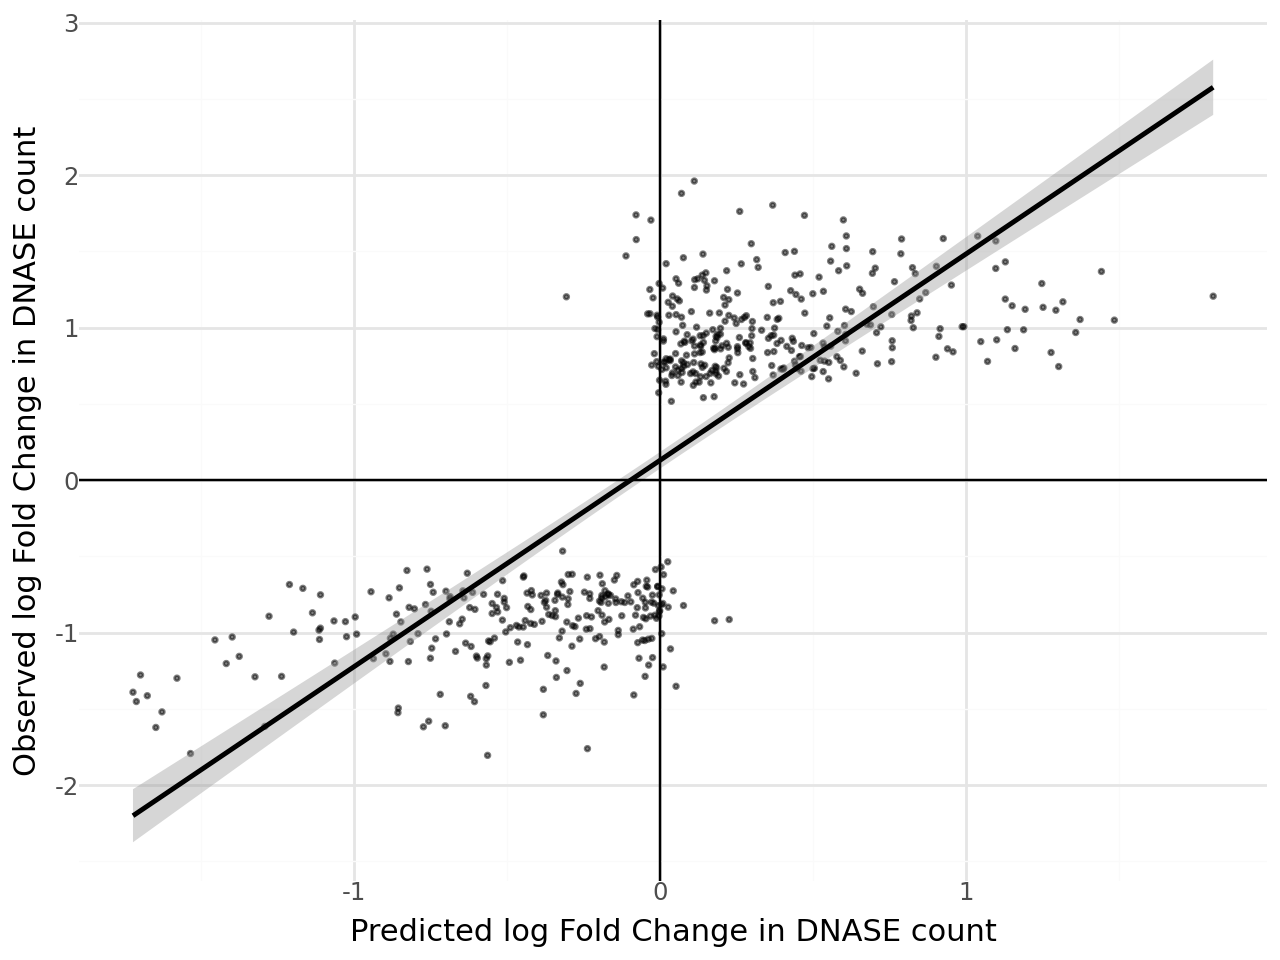

In [150]:
plot_df = all_vars_agg_pos.query('method == "logFC"').copy()
plot_df['pred_effect'] = plot_df.apply(lambda x: -x['pred_effect'] if x['Ref_allele'] == 'var.allele1' else x['pred_effect'],axis=1)

p = (p9.ggplot(plot_df,
           mapping=p9.aes(x='pred_effect/np.log(2)', y='obs.estimate'))#, color='Direction')) 
 + p9.geom_point(alpha=0.5,size=0.5,raster=True)
 + p9.geom_smooth(method="lm")
 #+ p9.scale_color_manual(['crimson','steelblue'])
 #+ p9.scale_y_log10()
 #+ p9.scale_x_log10()
 + p9.geom_hline(yintercept=0)
 + p9.geom_vline(xintercept=0)
 + p9.theme_minimal()
 + p9.labs(y='Observed log Fold Change in DNASE count', x='Predicted log Fold Change in DNASE count')
)

p.save(filename='Graphics/dsqtl.jpg', height=4, width=4, dpi=300)

p

# caQTL

In [4]:
glob.glob('Data/chrombpnet/caqtls.*.tsv')

['Data/chrombpnet/caqtls.eu.lcls.benchmarking.all.tsv',
 'Data/chrombpnet/caqtls.smc.benchmarking.all.tsv',
 'Data/chrombpnet/caqtls.african.lcls.benchmarking.all.tsv',
 'Data/chrombpnet/caqtls.microglia.benchmarking.all.tsv',
 'Data/chrombpnet/caqtls.african.lcls.asb.benchmarking.all.tsv']

In [5]:
pd.read_table('Data/chrombpnet/caqtls.african.lcls.asb.benchmarking.all.tsv')

,var.chr,var.pos_hg38,allele1,allele2,var.isused,var.snp_id,obs.meanLog2FC,pred.chrombpnet.encsr637xsc.variantscore.logfc,pred.chrombpnet.encsr637xsc.variantscore.jsd,pred.chrombpnet.encsr000emt.variantscore.logfc,pred.chrombpnet.encsr000emt.variantscore.jsd,pred.chrombpnet.encsr637xsc_50m.variantscore.logfc,pred.chrombpnet.encsr637xsc_50m.variantscore.jsd
0,chr1,976215,A,G,True,1_976215_A_G,-1.852605,-0.079329,-0.061612,0.082073,0.026010,0.075894,0.038511
1,chr1,1000079,A,G,True,1_1000079_A_G,-2.087074,-0.002563,-0.013885,-0.016055,-0.014341,0.005725,0.013705
2,chr1,1038800,T,G,True,1_1038800_G_T,-3.172063,0.000583,0.013765,-0.027916,-0.015095,-0.035529,-0.016815
3,chr1,1038819,T,C,True,1_1038819_C_T,-2.390945,0.223319,0.023942,0.034382,0.015420,0.109847,0.020354
4,chr1,1038845,G,A,True,1_1038845_A_G,-2.163432,-0.441510,-0.035797,-0.276909,-0.046153,-0.377451,-0.036387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7554,chr22,45413743,A,C,True,22_45413743_C_A,2.318303,0.038155,0.019803,0.035438,0.018440,0.019085,0.013788
7555,chr22,46773373,C,T,False,22_46773373_C_T,2.662931,0.371918,0.035563,0.302606,0.059008,0.241287,0.030801
7556,chr22,47001539,A,G,False,22_47001539_G_A,2.249763,0.723060,0.045371,0.393396,0.066974,0.415233,0.052056
7557,chr22,47918714,G,A,True,22_47918714_G_A,3.353036,0.706527,0.030788,0.327295,0.043628,0.450246,0.039984


In [53]:
df_list = []
for path in glob.glob('Data/chrombpnet/caqtls.*.tsv'):
    df = pd.read_table(path).rename(columns={'allele1':'var.allele1',
                                             'allele2':'var.allele2',
                                             'var.ref':'var.allele1',
                                             'var.alt':'var.allele2'})
    df = df.loc[df['var.isused']]
    df = df[['var.chr','var.pos_hg38','var.allele1','var.allele2']]
    #df['dataset'] = path.split('/')[-1]
    df_list.append(df)
caqtl = pd.concat(df_list)

In [54]:
caqtl = caqtl.drop_duplicates()
# fix broken variant
caqtl['var.allele1'] = caqtl.progress_apply(lambda x: 'G' if (x['var.pos_hg38'] == 55834088 and x['var.chr'] == "chr16" and x['var.allele1'] == 'C') else x['var.allele1'], axis=1)


00%|██████████| 156990/156990 [00:01<00:00, 154048.24it/s]

In [55]:
variants_df = caqtl.rename(columns={'var.chr':'Chromosome','var.pos_hg38':'Pos'})

In [56]:
variants_df['End'] = variants_df['Pos']
variants_df['Start'] = variants_df['Pos'] - 1

# assign ref and alt
fasta = pyfaidx.Fasta(fasta_file)
check = variants_df.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper() in [x['var.allele1'],x['var.allele2']],axis=1)
assert check.sum() == len(check)
variants_df['Ref'] = variants_df.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper(),axis=1)



00%|██████████| 156990/156990 [00:02<00:00, 57017.24it/s]

In [57]:
variants_df['Alt'] = variants_df.progress_apply(lambda x: x['var.allele1'] if x['var.allele2'] == x['Ref'] else x['var.allele2'] ,axis=1)


00%|██████████| 156990/156990 [00:01<00:00, 119157.01it/s]

In [58]:
variants_df['variant'] = variants_df['Chromosome'] + "_" + variants_df['Start'].astype('str') + "_" + variants_df['Alt']

In [59]:
variants_df[['Chromosome','Start','End','Ref', 'Alt','variant']].drop_duplicates('variant').to_csv('Data/chrombpnet/caqtl.all_vars.tsv',sep="\t",index=None)

In [60]:
pd.read_table('Data/chrombpnet/caqtl.all_vars.tsv').drop_duplicates('variant')

,Chromosome,Start,End,Ref,Alt,variant
0,chr1,817185,817186,G,A,chr1_817185_A
1,chr1,817212,817213,T,G,chr1_817212_G
2,chr1,817236,817237,C,A,chr1_817236_A
3,chr1,817340,817341,A,G,chr1_817340_G
4,chr1,827251,827252,T,A,chr1_827251_A
...,...,...,...,...,...,...
149333,chr21,26170137,26170138,G,T,chr21_26170137_T
149334,chr21,31137088,31137089,G,A,chr21_31137088_A
149335,chr22,35540362,35540363,G,T,chr22_35540362_T
149336,chr22,36419519,36419520,G,A,chr22_36419519_A


## Write Config

In [18]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_caqtl_keepscale_logL2_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_caqtl_keepscale_logL2_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/chrombpnet/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/chrombpnet/caqtl.all_vars.tsv',
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'prediction_bin_mode': 32,
                  'track_subset': 'DNASE&ATAC',
                  'metric': 'logL2',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

In [13]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_caqtl_keepscale_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_caqtl_keepscale_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/chrombpnet/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/chrombpnet/caqtl.all_vars.tsv',
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'prediction_bin_mode': 32,
                  'track_subset': 'DNASE&ATAC',
                  'metric': 'logfc',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run

In [109]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
Pipe/Configs/borzoi_caqtl_keepscale_3.txt \
doing_stuff_in_the_arena \
Pipe/job_reports/

Submitted batch job 16611796


In [22]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
Pipe/Configs/borzoi_caqtl_keepscale_logL2_3.txt \
doing_stuff_in_the_arena \
Pipe/job_reports/

Submitted batch job 16612916


## Analyze

In [80]:
def sanitize_df(df, fasta_file):
    df = df.rename(columns={'allele1':'var.allele1',
                            'allele2':'var.allele2',
                            'var.ref':'var.allele1',
                            'var.alt':'var.allele2'})
    df = df.loc[df['var.isused']]
    df['var.allele1'] = df.progress_apply(lambda x: 'G' if (x['var.pos_hg38'] == 55834088 and x['var.chr'] == "chr16" and x['var.allele1'] == 'C') else x['var.allele1'], axis=1)
    df = df.rename(columns={'var.chr':'Chromosome','var.pos_hg38':'Pos'})
    df['End'] = df['Pos']
    df['Start'] = df['Pos'] - 1
    # assign ref and alt
    fasta = pyfaidx.Fasta(fasta_file)
    check = df.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper() in [x['var.allele1'],x['var.allele2']],axis=1)
    assert check.sum() == len(check)
    df['Ref'] = df.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper(),axis=1)
    df['Ref_allele'] = df.progress_apply(lambda x: 'var.allele2' if x['var.allele2'] == x['Ref'] else 'var.allele1',axis=1)
    df['Alt'] = df.progress_apply(lambda x: x['var.allele1'] if x['var.allele2'] == x['Ref'] else x['var.allele2'] ,axis=1)
    df['variant'] = df['Chromosome'] + "_" + df['Start'].astype('str') + "_" + df['Alt']
    return df

### LCL - EU

In [81]:
lcl_eu = pd.read_table('Data/chrombpnet/caqtls.eu.lcls.benchmarking.all.tsv')
lcl_eu = sanitize_df(lcl_eu, fasta_file)
lcl_eu['tissue'] = 'GM12878'






00%|██████████| 95065/95065 [00:00<00:00, 124011.87it/s]

#### Map

In [82]:
def make_borzoi_mapping(adata):
    mapping = {
         'GM12878':['DNASE:GM12878'],
    }
    return mapping

#### Load

In [83]:
rows = []
df_list = []
mapping = None
for model in ['borzoi']:#,'flashzoi']:
    for method in ['logFC','logL2']:
        for rep in tqdm.tqdm([0,1,2,3]):
            adata_list = []

            method_string = "" if method == "logFC" else "_"+method
            paths = sorted(glob.glob(f'Results/chrombpnet/Chunky/{model}_caqtl_keepscale{method_string}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if mapping is None:
                    mapping = make_borzoi_mapping(adata)
                mapping = mapping
                adata.obs_names = adata.obs['variant'].astype('str')
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            # deduplicate if need be (ran this with undedup'd accidentally)
            if method == "logFC":
                adata = adata[np.array(adata.obs['variant'].reset_index(drop=True).drop_duplicates(keep='first').index)]
            adata.obs_names = adata.obs['variant'].astype('str')
            
            for tissue in mapping.keys():
                reduced_df = lcl_eu.query('tissue == @tissue')
                assert len(reduced_df) > 0
            
                reduced_adata = adata[adata.obs.index.isin(set(reduced_df['variant'])), adata.var.description.isin(mapping[tissue])]
                snp_effects = pd.DataFrame({'variant':reduced_adata.obs_names,
                                            #'pred_effect':reduced_adata.X.mean(axis=1)})
                                            'pred_effect':reduced_adata.X[:,0]})# Dr Nair only uses first DNASE track
                snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                
                reduced_df = reduced_df.merge(snp_effects, on=['variant'])
                assert len(reduced_df) == len(snp_effects)

                reduced_df['method'] = method
                reduced_df['model'] = model
                reduced_df['rep'] = rep
                df_list.append(reduced_df)

all_vars = pd.concat(df_list)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


00%|██████████| 4/4 [00:33<00:00,  8.33s/it]

In [84]:
for rep in [0,1,2,3]:
    for method in ['logFC','logL2']:
        assert len(all_vars.query('model == "borzoi" and rep == @rep and method == @method')) == len(lcl_eu)

In [85]:
all_vars = get_signed_logL2(all_vars)

#### Analyze

In [86]:
threshold = 6 # as in chrombpnet paper
all_vars['obs.label'] = all_vars["obs.pval"].apply(lambda x: int(np.log10(x)*-1 > threshold))

In [87]:
chrombpnet_models = [x for x in all_vars.columns if 'chrombpnet' in x or 'gkm' in x or 'enformer' in x]
chrombpnet_preds = all_vars.query('model == "borzoi" and rep == 0 and method == "logFC"')[['variant','tissue','obs.label','obs.beta']+chrombpnet_models].melt(id_vars=['variant','tissue','obs.label','obs.beta'],var_name='model',value_name='pred_effect')
assert len(chrombpnet_preds['variant'].drop_duplicates()) == len(lcl_eu)

In [90]:
all_vars_agg = all_vars.groupby(['variant','tissue','model','method','obs.label','Ref_allele'],observed=True)['pred_effect'].mean().reset_index()

In [93]:
compute_pred_corr(all_vars_agg, chrombpnet_preds, "pred.chrombpnet.encsr637xsc.variantscore.logfc", abs_corr = True, switch_refalt = False)

(0.6937341158047986, 0.4408170290890774)

In [94]:
lcleu_metric_df = get_classification_metrics_local(all_vars, all_vars_agg, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models)
lcleu_metric_df.query('method != "signed_logL2"').sort_values('auprc',ascending=False).head(20)


00%|██████████| 13/13 [00:02<00:00,  6.49it/s]

,model,method,replicate,tissue,auroc,auprc,n,class_balance
12,borzoi,logFC,ensemble,GM12878,0.722390,0.341300,95065,0.083101
9,borzoi,logFC,3,GM12878,0.717518,0.328695,95065,0.083101
0,borzoi,logFC,0,GM12878,0.713753,0.325535,95065,0.083101
3,borzoi,logFC,1,GM12878,0.714163,0.325227,95065,0.083101
17,chrombpnet_encsr637xsc,logfc,0,GM12878,0.702707,0.317924,95065,0.083101
6,borzoi,logFC,2,GM12878,0.711912,0.315757,95065,0.083101
13,borzoi,logL2,ensemble,GM12878,0.701962,0.305953,95065,0.083101
26,enformer_encsr000emt,local_logfc,0,GM12878,0.708142,0.304847,95065,0.083101
19,chrombpnet_encsr637xsc,ips,0,GM12878,0.704164,0.299486,95065,0.083101
1,borzoi,logL2,0,GM12878,0.692367,0.296528,95065,0.083101


In [95]:
all_vars_agg_pos = all_vars.loc[all_vars['obs.label'] == 1].groupby(['variant','Ref_allele','method','tissue','model','obs.beta'],observed=True)['pred_effect'].mean().reset_index()

In [97]:
compute_pred_corr(all_vars_agg_pos, chrombpnet_preds, "pred.chrombpnet.encsr637xsc.variantscore.logfc", abs_corr = False, switch_refalt = False)

(0.5083548788596342, 0.5515813292249078)

In [68]:
lcleu_corr_df = get_corr_metrics_local(all_vars, all_vars_agg_pos, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models, obs_name='obs.beta', switch_refalt=False)
lcleu_corr_df.sort_values('r',ascending=False).head(20)


00%|██████████| 13/13 [00:02<00:00,  4.90it/s]

,model,method,replicate,tissue,r,sign_concord,rho,n
17,chrombpnet_encsr637xsc,logfc,0,GM12878,0.550323,0.734430,0.574745,7900
23,chrombpnet_encsr000emt,logfc,0,GM12878,0.542018,0.716456,0.554269,7900
12,borzoi,logFC,ensemble,GM12878,0.536947,0.759873,0.604423,7900
20,chrombpnet_encsr637xsc_50m,logfc,0,GM12878,0.530104,0.717848,0.549900,7900
0,borzoi,logFC,0,GM12878,0.530094,0.746076,0.584146,7900
9,borzoi,logFC,3,GM12878,0.526844,0.748861,0.589181,7900
3,borzoi,logFC,1,GM12878,0.524125,0.750759,0.589426,7900
26,enformer_encsr000emt,local_logfc,0,GM12878,0.523015,0.748608,0.579301,7900
13,borzoi,signed_logL2,ensemble,GM12878,0.514223,0.759367,0.588457,7900
1,borzoi,signed_logL2,0,GM12878,0.514021,0.746076,0.566014,7900


In [69]:
lcleu_corr_df.sort_values('rho',ascending=False).head(5)

,model,method,replicate,tissue,r,sign_concord,rho,n
12,borzoi,logFC,ensemble,GM12878,0.536947,0.759873,0.604423,7900
3,borzoi,logFC,1,GM12878,0.524125,0.750759,0.589426,7900
9,borzoi,logFC,3,GM12878,0.526844,0.748861,0.589181,7900
13,borzoi,signed_logL2,ensemble,GM12878,0.514223,0.759367,0.588457,7900
0,borzoi,logFC,0,GM12878,0.530094,0.746076,0.584146,7900


### LCL - African

In [98]:
lcl_african = pd.read_table('Data/chrombpnet/caqtls.african.lcls.benchmarking.all.tsv')
lcl_african = sanitize_df(lcl_african, fasta_file)
lcl_african['tissue'] = 'GM12878'






00%|██████████| 79026/79026 [00:00<00:00, 114177.13it/s]

#### Map

In [99]:
def make_borzoi_mapping(adata):
    mapping = {
         'GM12878':['DNASE:GM12878'],
    }
    return mapping

#### Load

In [100]:
rows = []
df_list = []
mapping = None
for model in ['borzoi']:#,'flashzoi']:
    for method in ['logFC','logL2']:#['logFC']:#,'logL2']:
        for rep in tqdm.tqdm([0,1,2,3]):
            adata_list = []

            method_string = "" if method == "logFC" else "_"+method
            paths = sorted(glob.glob(f'Results/chrombpnet/Chunky/{model}_caqtl_keepscale{method_string}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if mapping is None:
                    mapping = make_borzoi_mapping(adata)
                mapping = mapping
                adata.obs_names = adata.obs['variant'].astype('str')
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            # deduplicate if need be (ran this with undedup'd accidentally)
            adata = adata[np.array(adata.obs['variant'].reset_index(drop=True).drop_duplicates(keep='first').index)]
            adata.obs_names = adata.obs['variant'].astype('str')
            
            for tissue in mapping.keys():
                reduced_df = lcl_african.query('tissue == @tissue')
                assert len(reduced_df) > 0
            
                reduced_adata = adata[adata.obs.index.isin(set(reduced_df['variant'])), adata.var.description.isin(mapping[tissue])]
                snp_effects = pd.DataFrame({'variant':reduced_adata.obs_names,
                                            #'pred_effect':reduced_adata.X.mean(axis=1)})
                                            'pred_effect':reduced_adata.X[:,0]})# Dr Nair only uses first DNASE track
                snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                
                reduced_df = reduced_df.merge(snp_effects, on=['variant'])
                assert len(reduced_df) == len(snp_effects)

                reduced_df['method'] = method
                reduced_df['model'] = model
                reduced_df['rep'] = rep
                df_list.append(reduced_df)

all_vars = pd.concat(df_list)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


00%|██████████| 4/4 [00:13<00:00,  3.33s/it]

In [101]:
for rep in [0,1,2,3]:
    for method in ['logFC','logL2']:
        assert len(all_vars.query('model == "borzoi" and rep == @rep and method == @method')) == len(lcl_african)

In [102]:
all_vars = get_signed_logL2(all_vars)

#### Analyze

In [103]:
chrombpnet_models = [x for x in all_vars.columns if 'chrombpnet' in x or 'gkm' in x or 'enformer' in x]
chrombpnet_preds = all_vars.query('model == "borzoi" and rep == 0 and method == "logFC"')[['variant','tissue','obs.label','obs.beta']+chrombpnet_models].melt(id_vars=['variant','tissue','obs.label','obs.beta'],var_name='model',value_name='pred_effect')
assert len(chrombpnet_preds['variant'].drop_duplicates()) == len(lcl_african)

In [106]:
all_vars_agg = all_vars.groupby(['variant','tissue','model','method','obs.label','Ref_allele'],observed=True)['pred_effect'].mean().reset_index()

In [107]:
compute_pred_corr(all_vars_agg, chrombpnet_preds, "pred.chrombpnet.encsr637xsc.variantscore.logfc", abs_corr = True, switch_refalt = False)

(0.7050717917078548, 0.4759423529249746)

In [77]:
lclafrican_metric_df = get_classification_metrics_local(all_vars, all_vars_agg, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models)
lclafrican_metric_df.query('method != "signed_logL2"').sort_values('auprc',ascending=False).head(20)


00%|██████████| 25/25 [00:04<00:00,  5.10it/s]

,model,method,replicate,tissue,auroc,auprc,n,class_balance
12,borzoi,logFC,ensemble,GM12878,0.807044,0.479500,79026,0.086313
24,chrombpnet_yoruba,logfc,0,GM12878,0.793127,0.476065,79026,0.086313
30,chrombpnet_encsr637xsc,logfc,0,GM12878,0.793907,0.472632,79026,0.086313
22,chrombpnet_mende,logfc,0,GM12878,0.791556,0.472418,79026,0.086313
28,chrombpnet_luhya,logfc,0,GM12878,0.793264,0.472180,79026,0.086313
20,chrombpnet_esan,logfc,0,GM12878,0.792243,0.471999,79026,0.086313
18,chrombpnet_gambian,logfc,0,GM12878,0.788538,0.464839,79026,0.086313
9,borzoi,logFC,3,GM12878,0.799915,0.458948,79026,0.086313
0,borzoi,logFC,0,GM12878,0.798547,0.457518,79026,0.086313
26,chrombpnet_maasai,logfc,0,GM12878,0.783453,0.456741,79026,0.086313


In [110]:
all_vars_agg_pos = all_vars.loc[all_vars['obs.label'] == 1].groupby(['variant','Ref_allele','method','tissue','model','obs.beta'],observed=True)['pred_effect'].mean().reset_index()

In [111]:
compute_pred_corr(all_vars_agg_pos, chrombpnet_preds, "pred.chrombpnet.encsr637xsc.variantscore.logfc", abs_corr = False, switch_refalt = False)

(0.4834776254178131, 0.5662992154218235)

In [80]:
lclafrican_corr_df = get_corr_metrics_local(all_vars, all_vars_agg_pos, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models, obs_name='obs.beta', switch_refalt=False)
lclafrican_corr_df.sort_values('r',ascending=False).head(20)


00%|██████████| 25/25 [00:02<00:00,  8.93it/s]

,model,method,replicate,tissue,r,sign_concord,rho,n
22,chrombpnet_mende,logfc,0,GM12878,0.692923,0.823633,0.722004,6821
28,chrombpnet_luhya,logfc,0,GM12878,0.692544,0.821874,0.725274,6821
24,chrombpnet_yoruba,logfc,0,GM12878,0.692099,0.822900,0.726676,6821
25,chrombpnet_yoruba,jsd,0,GM12878,0.690152,0.822900,0.718528,6821
23,chrombpnet_mende,jsd,0,GM12878,0.690115,0.823633,0.715564,6821
20,chrombpnet_esan,logfc,0,GM12878,0.689633,0.815716,0.722095,6821
30,chrombpnet_encsr637xsc,logfc,0,GM12878,0.689079,0.827445,0.725931,6821
18,chrombpnet_gambian,logfc,0,GM12878,0.688174,0.820994,0.720806,6821
19,chrombpnet_gambian,jsd,0,GM12878,0.688057,0.820994,0.717595,6821
29,chrombpnet_luhya,jsd,0,GM12878,0.685664,0.821874,0.716143,6821


In [81]:
lclafrican_corr_df.sort_values('rho',ascending=False).head(5)

,model,method,replicate,tissue,r,sign_concord,rho,n
12,borzoi,logFC,ensemble,GM12878,0.665721,0.849582,0.736399,6821
24,chrombpnet_yoruba,logfc,0,GM12878,0.692099,0.822900,0.726676,6821
9,borzoi,logFC,3,GM12878,0.654012,0.844451,0.725997,6821
30,chrombpnet_encsr637xsc,logfc,0,GM12878,0.689079,0.827445,0.725931,6821
28,chrombpnet_luhya,logfc,0,GM12878,0.692544,0.821874,0.725274,6821


### LCL - ASB

In [38]:
asb = pd.read_table('Data/chrombpnet/caqtls.african.lcls.asb.benchmarking.all.tsv')
asb = sanitize_df(asb, fasta_file)
asb['tissue'] = 'GM12878'






00%|██████████| 5220/5220 [00:00<00:00, 75830.34it/s]

In [45]:
asb['obs.label'] = 1

#### Map

In [49]:
def make_borzoi_mapping(adata):
    mapping = {
         'GM12878':['DNASE:GM12878'],
    }
    return mapping

#### Load

In [50]:
rows = []
df_list = []
mapping = None
for model in ['borzoi']:#,'flashzoi']:
    for method in ['logFC','logL2']:
        for rep in tqdm.tqdm([0,1,2,3]):
            adata_list = []

            method_string = "" if method == "logFC" else "_"+method
            paths = sorted(glob.glob(f'Results/chrombpnet/Chunky/{model}_caqtl_keepscale{method_string}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if mapping is None:
                    mapping = make_borzoi_mapping(adata)
                mapping = mapping
                adata.obs_names = adata.obs['variant'].astype('str')
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            # deduplicate if need be (ran this with undedup'd accidentally)
            if method == "logFC":
                adata = adata[np.array(adata.obs['variant'].reset_index(drop=True).drop_duplicates(keep='first').index)]
            adata.obs_names = adata.obs['variant'].astype('str')
            
            for tissue in mapping.keys():
                reduced_df = asb.query('tissue == @tissue')
                assert len(reduced_df) > 0
            
                reduced_adata = adata[adata.obs.index.isin(set(reduced_df['variant'])), adata.var.description.isin(mapping[tissue])]
                snp_effects = pd.DataFrame({'variant':reduced_adata.obs_names,
                                            #'pred_effect':reduced_adata.X.mean(axis=1)})
                                            'pred_effect':reduced_adata.X[:,0]})# Dr Nair only uses first DNASE track
                snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                
                reduced_df = reduced_df.merge(snp_effects, on=['variant'])
                assert len(reduced_df) == len(snp_effects)

                reduced_df['method'] = method
                reduced_df['model'] = model
                reduced_df['rep'] = rep
                df_list.append(reduced_df)

all_vars = pd.concat(df_list)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


00%|██████████| 4/4 [00:19<00:00,  4.84s/it]

In [51]:
for rep in [0,1,2,3]:
    for method in ['logFC','logL2']:
        assert len(all_vars.query('model == "borzoi" and rep == @rep and method == @method')) == len(asb)

In [52]:
all_vars = get_signed_logL2(all_vars)

#### Analyze

In [55]:
chrombpnet_models = [x for x in all_vars.columns if 'chrombpnet' in x or 'gkm' in x or 'enformer' in x]
chrombpnet_preds = all_vars.query('model == "borzoi" and rep == 0 and method == "logFC"')[['variant','tissue','obs.label','obs.meanLog2FC']+chrombpnet_models].melt(id_vars=['variant','tissue','obs.label','obs.meanLog2FC'],var_name='model',value_name='pred_effect')
assert len(chrombpnet_preds['variant'].drop_duplicates()) == len(asb)

In [56]:
all_vars_agg_pos = all_vars.loc[all_vars['obs.label'] == 1].groupby(['variant','Ref_allele','method','tissue','model','obs.meanLog2FC'],observed=True)['pred_effect'].mean().reset_index()

In [57]:
asb_corr_df = get_corr_metrics_local(all_vars, all_vars_agg_pos, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models, obs_name='obs.meanLog2FC', switch_refalt=False)
asb_corr_df.sort_values('r',ascending=False).head(20)


00%|██████████| 7/7 [00:01<00:00,  5.93it/s]

,model,method,replicate,tissue,r,sign_concord,rho,n
15,chrombpnet_encsr637xsc,logfc,0,GM12878,0.683292,0.844636,0.710815,5220
18,chrombpnet_encsr000emt,jsd,0,GM12878,0.680838,0.839272,0.689525,5220
17,chrombpnet_encsr000emt,logfc,0,GM12878,0.670843,0.839272,0.696754,5220
19,chrombpnet_encsr637xsc_50m,logfc,0,GM12878,0.663663,0.837548,0.699972,5220
16,chrombpnet_encsr637xsc,jsd,0,GM12878,0.661974,0.844636,0.701370,5220
12,borzoi,logFC,ensemble,GM12878,0.654899,0.869157,0.719246,5220
20,chrombpnet_encsr637xsc_50m,jsd,0,GM12878,0.652624,0.837548,0.683024,5220
0,borzoi,logFC,0,GM12878,0.648067,0.854598,0.702352,5220
3,borzoi,logFC,1,GM12878,0.643403,0.856130,0.708131,5220
9,borzoi,logFC,3,GM12878,0.643160,0.860920,0.707062,5220


In [82]:
asb_corr_df.sort_values('rho',ascending=False).head(5)

,model,method,replicate,tissue,r,sign_concord,rho,n
12,borzoi,logFC,ensemble,GM12878,0.654899,0.869157,0.719246,5220
15,chrombpnet_encsr637xsc,logfc,0,GM12878,0.683292,0.844636,0.710815,5220
3,borzoi,logFC,1,GM12878,0.643403,0.856130,0.708131,5220
9,borzoi,logFC,3,GM12878,0.643160,0.860920,0.707062,5220
0,borzoi,logFC,0,GM12878,0.648067,0.854598,0.702352,5220


### Smooth muscle cell

In [ ]:
# unclear what track to match here

In [506]:
smc = pd.read_table('Data/chrombpnet/caqtls.smc.benchmarking.all.tsv')
smc = sanitize_df(smc, fasta_file)
smc['tissue'] = 'smc'
smc = smc.drop_duplicates(subset='variant') # weird
smc['obs.Effect_size'] = smc['obs.Effect_size'] - 0.5
smc['obs.label'] = 1






00%|██████████| 386/386 [00:00<00:00, 111371.08it/s]

#### Map

In [515]:
def make_borzoi_mapping(adata):
    mapping = {
         'smc':['DNASE:cardiac muscle cell'],#['DNASE:smooth muscle cell of the brain vasculature female']
    }
    return mapping

#### Load

In [516]:
rows = []
df_list = []
mapping = None
for model in ['borzoi']:#,'flashzoi']:
    for method in ['logFC','logL2']:
        for rep in tqdm.tqdm([0,1,2,3]):
            adata_list = []

            method_string = "" if method == "logFC" else "_"+method
            paths = sorted(glob.glob(f'Results/chrombpnet/Chunky/{model}_caqtl_keepscale{method_string}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if mapping is None:
                    mapping = make_borzoi_mapping(adata)
                mapping = mapping
                adata.obs_names = adata.obs['variant'].astype('str')
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            # deduplicate if need be (ran this with undedup'd accidentally)
            adata = adata[np.array(adata.obs['variant'].reset_index(drop=True).drop_duplicates(keep='first').index)]
            adata.obs_names = adata.obs['variant'].astype('str')
            
            for tissue in mapping.keys():
                reduced_df = smc.query('tissue == @tissue')
                assert len(reduced_df) > 0
            
                reduced_adata = adata[adata.obs.index.isin(set(reduced_df['variant'])), adata.var.description.isin(mapping[tissue])]
                snp_effects = pd.DataFrame({'variant':reduced_adata.obs_names,
                                            #'pred_effect':reduced_adata.X.mean(axis=1)})
                                            'pred_effect':reduced_adata.X[:,0]})
                snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                
                reduced_df = reduced_df.merge(snp_effects, on=['variant'])
                assert len(reduced_df) == len(snp_effects)

                reduced_df['method'] = method
                reduced_df['model'] = model
                reduced_df['rep'] = rep
                df_list.append(reduced_df)

all_vars = pd.concat(df_list)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


00%|██████████| 4/4 [00:13<00:00,  3.40s/it]

In [517]:
for rep in [0,1,2,3]:
    for method in ['logFC','logL2']:
        assert len(all_vars.query('model == "borzoi" and rep == @rep and method == @method')) == len(smc)

In [518]:
all_vars = get_signed_logL2(all_vars)

#### Analyze

In [519]:
chrombpnet_models = [x for x in all_vars.columns if 'chrombpnet' in x or 'gkm' in x or 'enformer' in x]
chrombpnet_preds = all_vars.query('model == "borzoi" and rep == 0 and method == "logFC"')[['variant','tissue','obs.label','obs.Effect_size']+chrombpnet_models].melt(id_vars=['variant','tissue','obs.label','obs.Effect_size'],var_name='model',value_name='pred_effect')
assert len(chrombpnet_preds['variant'].drop_duplicates()) == len(smc)

In [520]:
all_vars_agg_pos = all_vars.groupby(['variant','Ref_allele','tissue','model','method','obs.Effect_size'],observed=True)['pred_effect'].mean().reset_index()

In [521]:
smc_corr_df = get_corr_metrics_local(all_vars, all_vars_agg_pos, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models, obs_name='obs.Effect_size', switch_refalt=False)
smc_corr_df.sort_values('r',ascending=False).head(20)


00%|██████████| 3/3 [00:00<00:00, 21.74it/s]

,model,method,replicate,tissue,r,sign_concord,rho,n
15,chrombpnet_smc,logfc,0,smc,0.699417,0.873016,0.734825,378
16,chrombpnet_smc,jsd,0,smc,0.685850,0.873016,0.732000,378
14,borzoi,logFC,ensemble,smc,0.635505,0.867725,0.713512,378
8,borzoi,logFC,2,smc,0.633337,0.854497,0.706590,378
5,borzoi,logFC,1,smc,0.632528,0.857143,0.714805,378
2,borzoi,logFC,0,smc,0.623859,0.849206,0.707692,378
11,borzoi,logFC,3,smc,0.619969,0.846561,0.699769,378
6,borzoi,signed_logL2,2,smc,0.618084,0.854497,0.671165,378
12,borzoi,signed_logL2,ensemble,smc,0.617553,0.867725,0.681635,378
3,borzoi,signed_logL2,1,smc,0.611459,0.857143,0.678481,378


### Microglia

In [83]:
microglia = pd.read_table('Data/chrombpnet/caqtls.microglia.benchmarking.all.tsv')
microglia = sanitize_df(microglia, fasta_file)
microglia['tissue'] = 'microglia'
microglia = microglia.drop_duplicates(subset='variant') # weird
microglia['obs.label'] = 1






00%|██████████| 877/877 [00:00<00:00, 72245.99it/s]

#### Map

In [84]:
def make_borzoi_mapping(adata):
    mapping = {
         'microglia':['ATAC:Microglia'],
    }
    return mapping

#### Load

In [85]:
rows = []
df_list = []
mapping = None
for model in ['borzoi']:#,'flashzoi']:
    for method in ['logFC','logL2']:
        for rep in tqdm.tqdm([0,1,2,3]):
            adata_list = []

            method_string = "" if method == "logFC" else "_"+method
            paths = sorted(glob.glob(f'Results/chrombpnet/Chunky/{model}_caqtl_keepscale{method_string}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
            for path in paths:
                adata = ad.read_h5ad(path)
                if mapping is None:
                    mapping = make_borzoi_mapping(adata)
                mapping = mapping
                adata.obs_names = adata.obs['variant'].astype('str')
                adata_list.append(adata)
            
            adata = ad.concat(adata_list, merge='same')
            # deduplicate if need be (ran this with undedup'd accidentally)
            adata = adata[np.array(adata.obs['variant'].reset_index(drop=True).drop_duplicates(keep='first').index)]
            adata.obs_names = adata.obs['variant'].astype('str')
            
            for tissue in mapping.keys():
                reduced_df = microglia.query('tissue == @tissue')
                assert len(reduced_df) > 0
            
                reduced_adata = adata[adata.obs.index.isin(set(reduced_df['variant'])), adata.var.description.isin(mapping[tissue])]
                snp_effects = pd.DataFrame({'variant':reduced_adata.obs_names,
                                            'pred_effect':reduced_adata.X.mean(axis=1)})
                                            #'pred_effect':reduced_adata.X[:,0]})
                snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                
                reduced_df = reduced_df.merge(snp_effects, on=['variant'])
                assert len(reduced_df) == len(snp_effects)

                reduced_df['method'] = method
                reduced_df['model'] = model
                reduced_df['rep'] = rep
                df_list.append(reduced_df)

all_vars = pd.concat(df_list)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


00%|██████████| 4/4 [00:20<00:00,  5.03s/it]

In [86]:
for rep in [0,1,2,3]:
    for method in ['logFC','logL2']:
        assert len(all_vars.query('model == "borzoi" and rep == @rep and method == @method')) == len(microglia)

In [87]:
all_vars = get_signed_logL2(all_vars)

#### Analyze

In [88]:
chrombpnet_models = [x for x in all_vars.columns if 'chrombpnet' in x or 'gkm' in x or 'enformer' in x]
chrombpnet_preds = all_vars.query('model == "borzoi" and rep == 0 and method == "logFC"')[['variant','tissue','obs.label','obs.Beta']+chrombpnet_models].melt(id_vars=['variant','tissue','obs.label','obs.Beta'],var_name='model',value_name='pred_effect')
assert len(chrombpnet_preds['variant'].drop_duplicates()) == len(microglia)

In [89]:
all_vars_agg_pos = all_vars.groupby(['variant','Ref_allele','tissue','model','method','obs.label','obs.Beta'],observed=True)['pred_effect'].mean().reset_index()

In [90]:
microglia_corr_df = get_corr_metrics_local(all_vars, all_vars_agg_pos, extra_preds=chrombpnet_preds, extra_models=chrombpnet_models, obs_name='obs.Beta', switch_refalt=True)
microglia_corr_df.sort_values('r',ascending=False).head(20)


00%|██████████| 3/3 [00:00<00:00,  9.63it/s]

,model,method,replicate,tissue,r,sign_concord,rho,n
12,borzoi,logFC,ensemble,microglia,0.620475,0.769319,0.653049,867
6,borzoi,logFC,2,microglia,0.614480,0.782007,0.649572,867
9,borzoi,logFC,3,microglia,0.611493,0.777393,0.657417,867
3,borzoi,logFC,1,microglia,0.609949,0.772780,0.640887,867
0,borzoi,logFC,0,microglia,0.609211,0.764706,0.645879,867
15,chrombpnet_microglia,logfc,0,microglia,0.601572,0.765859,0.632916,867
16,chrombpnet_microglia,jsd,0,microglia,0.601324,0.765859,0.615129,867
13,borzoi,signed_logL2,ensemble,microglia,0.597474,0.775087,0.645505,867
7,borzoi,signed_logL2,2,microglia,0.593596,0.782007,0.641845,867
1,borzoi,signed_logL2,0,microglia,0.586408,0.764706,0.634631,867


# Combined Plot for Accessibility data

In [92]:
dsqtl_metric_df['study'] = "LCL Yoruba (DNASE)"
lclafrican_metric_df['study'] = "LCL African (ATAC)"
lcleu_metric_df['study'] = "LCL EU (ATAC)"
combined_metric_df = pd.concat([dsqtl_metric_df,lclafrican_metric_df,lcleu_metric_df])

In [94]:
combined_metric_df.query('method == "logFC" and replicate == "ensemble"')

,model,method,replicate,tissue,auroc,auprc,n,class_balance,study
12,borzoi,logFC,ensemble,GM12878,0.945534,0.591344,27373,0.020458,LCL Yoruba (DNASE)
12,borzoi,logFC,ensemble,GM12878,0.807044,0.479500,79026,0.086313,LCL African (ATAC)
12,borzoi,logFC,ensemble,GM12878,0.722390,0.341300,95065,0.083101,LCL EU (ATAC)


In [114]:
plot_ap = []
for model in ['Borzoi (Ensemble)', 'Borzoi (Rep 0)', 'Chrombpnet (Best)', 'Chrombpnet (Matched)']:
    if model == 'Borzoi (Ensemble)':
        rows = combined_metric_df.query('model == "borzoi" and method == "logFC" and replicate == "ensemble"')
        rows['Name'] = model
        plot_ap.append(rows[['Name','study','auprc']])
    if model == 'Borzoi (Rep 0)':
        rows = combined_metric_df.query('model == "borzoi" and method == "logFC" and replicate == 0')
        #rows = rows.groupby(['study'])['auprc'].median().reset_index()
        rows['Name'] = model
        plot_ap.append(rows[['Name','study','auprc']])
    if model == 'Chrombpnet (Best)':
        rows = combined_metric_df.loc[combined_metric_df.model.str.contains('chrombpnet')]
        rows = rows.groupby(['study'])['auprc'].max().reset_index()
        rows['Name'] = model
        plot_ap.append(rows[['Name','study','auprc']])
    if model == 'Chrombpnet (Matched)':
        rows = combined_metric_df.loc[combined_metric_df.model.str.contains('chrombpnet_encsr000emt')]
        rows = rows.groupby(['study'])['auprc'].max().reset_index()
        rows['Name'] = model
        plot_ap.append(rows[['Name','study','auprc']])
plot_ap = pd.concat(plot_ap)

In [115]:
plot_ap.sort_values(['study','auprc'],ascending=False)

,Name,study,auprc
12,Borzoi (Ensemble),LCL Yoruba (DNASE),0.591344
0,Borzoi (Rep 0),LCL Yoruba (DNASE),0.554213
2,Chrombpnet (Best),LCL Yoruba (DNASE),0.538238
2,Chrombpnet (Matched),LCL Yoruba (DNASE),0.429369
12,Borzoi (Ensemble),LCL EU (ATAC),0.341300
0,Borzoi (Rep 0),LCL EU (ATAC),0.325535
1,Chrombpnet (Best),LCL EU (ATAC),0.317924
1,Chrombpnet (Matched),LCL EU (ATAC),0.290249
12,Borzoi (Ensemble),LCL African (ATAC),0.479500
0,Chrombpnet (Best),LCL African (ATAC),0.476065


/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: Graphics/ap_compare.jpg


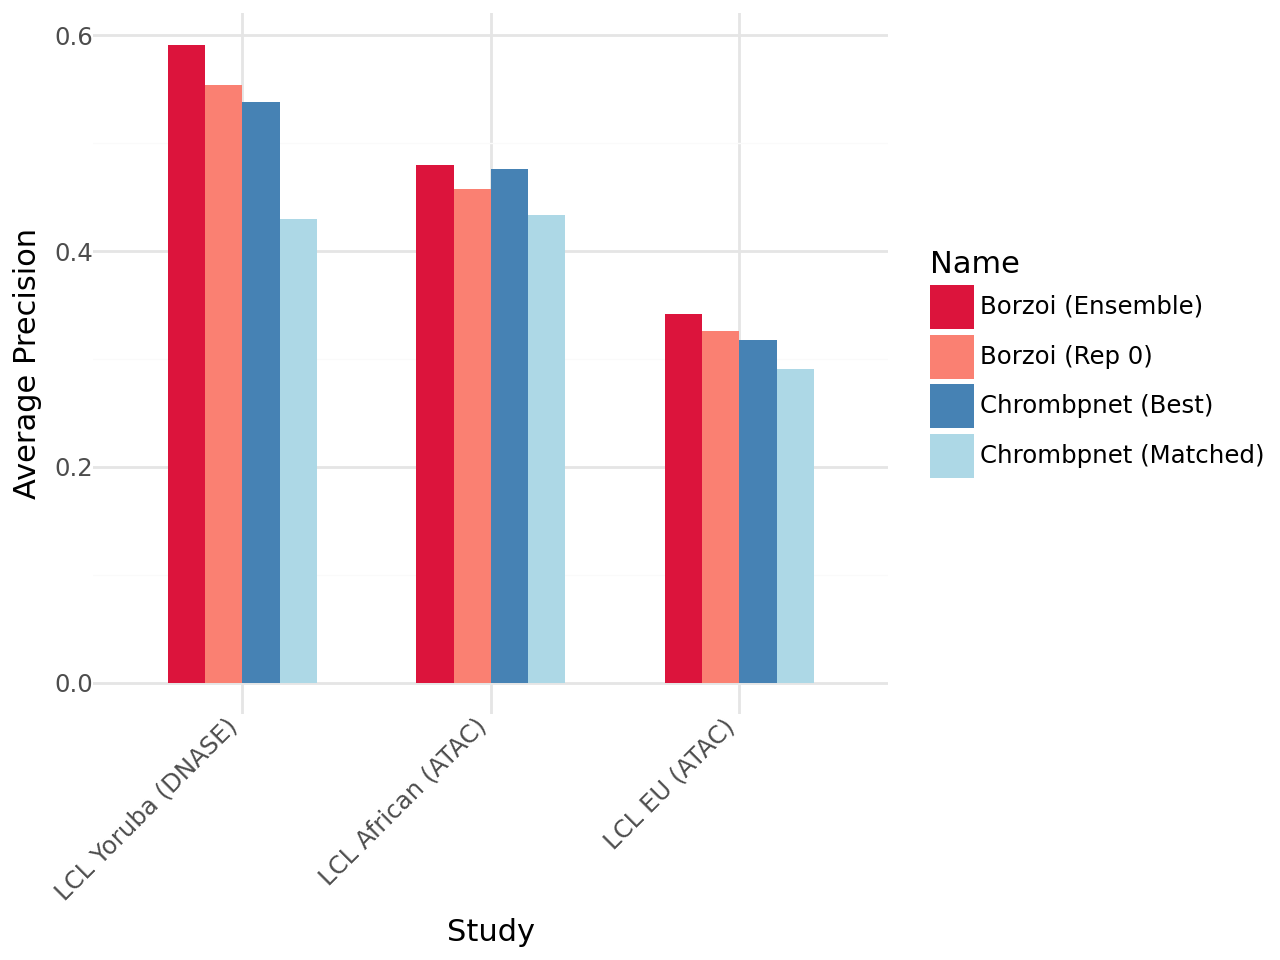

In [192]:
plot_ap['study'] = pd.Categorical(plot_ap['study'],categories=["LCL Yoruba (DNASE)", "LCL African (ATAC)", "LCL EU (ATAC)"])

p = (p9.ggplot(plot_ap, mapping=p9.aes(x='study', y='auprc', fill='Name')) 
 + p9.geom_bar(stat='identity',position='dodge', width = 0.6)
 + p9.scale_fill_manual(['crimson','salmon','steelblue','lightblue'])
 + p9.theme_minimal()
 + p9.labs(y='Average Precision',x='Study')
 + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)

p.save(filename='Graphics/ap_compare.jpg', height=4, width=6, dpi=300)

p

In [119]:
dsqtl_corr_df['study'] = "LCL Yoruba (DNASE)"
microglia_corr_df['study'] = "Microglia (ATAC)"
asb_corr_df['study'] = "LCL ASB (ATAC)"
lclafrican_corr_df['study'] = "LCL African (ATAC)"
lcleu_corr_df['study'] = "LCL EU (ATAC)"
combined_corr_df = pd.concat([dsqtl_corr_df,microglia_corr_df,asb_corr_df,lclafrican_corr_df,lcleu_corr_df])

In [122]:
plot_corr = []
for model in ['Borzoi (Ensemble)', 'Borzoi (Rep 0)', 'Chrombpnet (Best)', 'Chrombpnet (Matched)']:
    if model == 'Borzoi (Ensemble)':
        rows = combined_corr_df.query('model == "borzoi" and method == "logFC" and replicate == "ensemble"')
        rows['Name'] = model
        plot_corr.append(rows[['Name','study','r','rho']])
    if model == 'Borzoi (Rep 0)':
        rows = combined_corr_df.query('model == "borzoi" and method == "logFC" and replicate == 0')
        #rows = rows.groupby(['study'])['auprc'].median().reset_index()
        rows['Name'] = model
        plot_corr.append(rows[['Name','study','r','rho']])
    if model == 'Chrombpnet (Best)':
        rows = combined_corr_df.loc[combined_corr_df.model.str.contains('chrombpnet')]
        rows = rows.groupby(['study'])[['r','rho']].max().reset_index()
        rows['Name'] = model
        plot_corr.append(rows[['Name','study','r','rho']])
    if model == 'Chrombpnet (Matched)':
        rows = combined_corr_df.loc[combined_corr_df.model.str.contains('chrombpnet_encsr000emt|chrombpnet_microglia')]
        rows = rows.groupby(['study'])[['r','rho']].max().reset_index()
        rows['Name'] = model
        plot_corr.append(rows[['Name','study','r','rho']])
plot_corr = pd.concat(plot_corr)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: Graphics/corr_compare.jpg


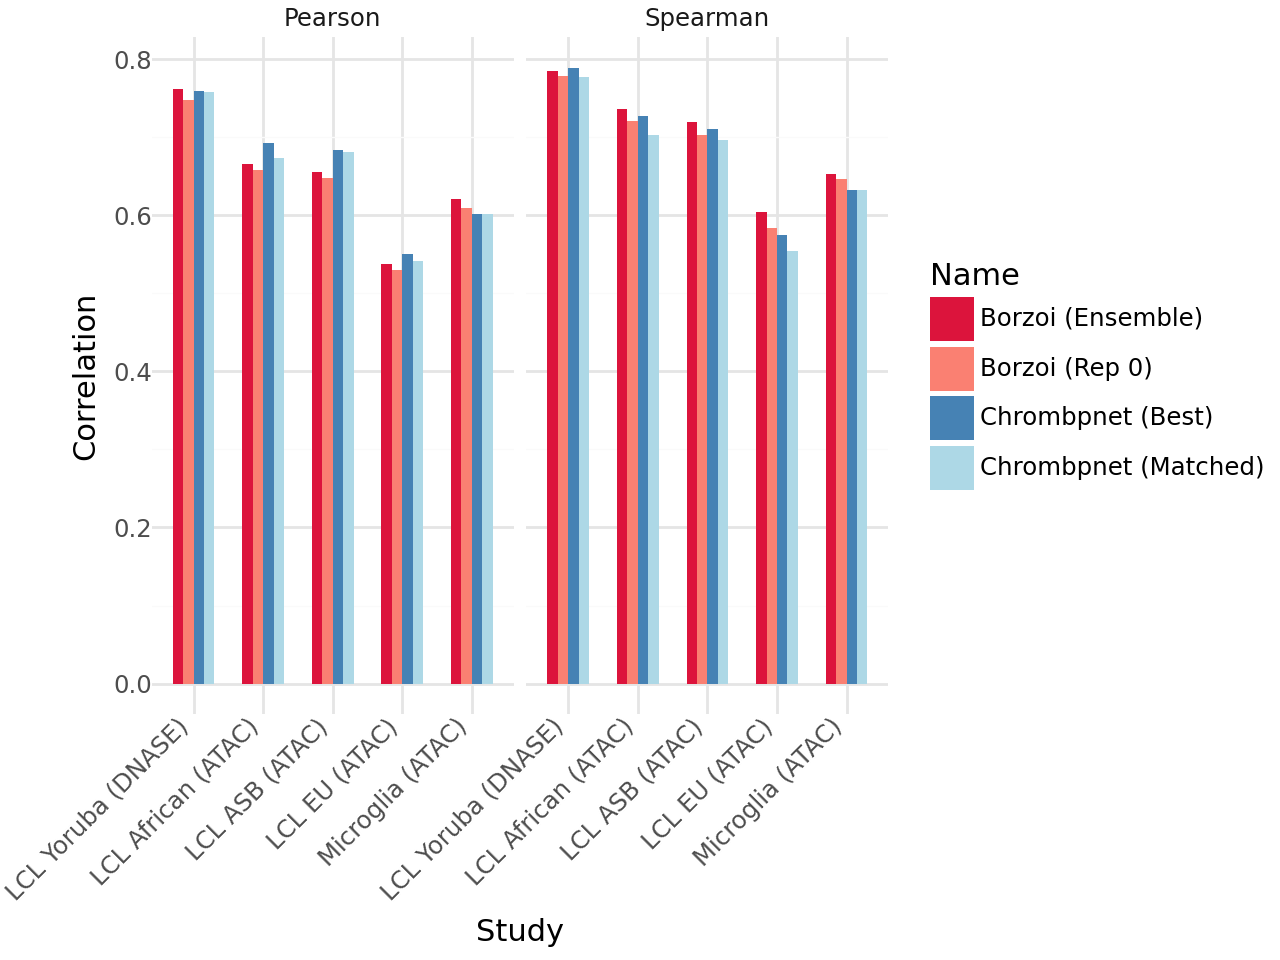

In [193]:
plot_corr['study'] = pd.Categorical(plot_corr['study'],categories=["LCL Yoruba (DNASE)", "LCL African (ATAC)", "LCL ASB (ATAC)", "LCL EU (ATAC)","Microglia (ATAC)"])

plot_corr_melt = plot_corr.melt(id_vars=['study','Name'])
plot_corr_melt['variable'] = plot_corr_melt['variable'].apply(lambda x: 'Pearson' if x == 'r' else "Spearman") 

p = (p9.ggplot(plot_corr_melt, mapping=p9.aes(x='study', y='value', fill='Name')) 
 + p9.geom_bar(stat='identity',position='dodge', width = 0.6)
 + p9.scale_fill_manual(['crimson','salmon','steelblue','lightblue'])
 + p9.theme_minimal()
 + p9.labs(y='Correlation',x='Study')
 #+ p9.coord_cartesian(ylim=(0.4,0.8))
 + p9.facet_wrap('~variable')
 + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)

p.save(filename='Graphics/corr_compare.jpg', height=4, width=6, dpi=300)

p

In [125]:
plot_corr.sort_values(['study','rho'],ascending=False)

,Name,study,r,rho
12,Borzoi (Ensemble),Microglia (ATAC),0.620475,0.653049
0,Borzoi (Rep 0),Microglia (ATAC),0.609211,0.645879
4,Chrombpnet (Best),Microglia (ATAC),0.601572,0.632916
4,Chrombpnet (Matched),Microglia (ATAC),0.601572,0.632916
3,Chrombpnet (Best),LCL Yoruba (DNASE),0.758618,0.789148
12,Borzoi (Ensemble),LCL Yoruba (DNASE),0.761539,0.785015
0,Borzoi (Rep 0),LCL Yoruba (DNASE),0.747032,0.778906
3,Chrombpnet (Matched),LCL Yoruba (DNASE),0.757596,0.776770
12,Borzoi (Ensemble),LCL EU (ATAC),0.536947,0.604423
0,Borzoi (Rep 0),LCL EU (ATAC),0.530094,0.584146


# eQTL

## Make Variant table

### Preprocess Susie

In [552]:
# Downloaded from https://github.com/eQTL-Catalogue/eQTL-Catalogue-resources/blob/master/data_tables/dataset_metadata.tsv
susie_datasets = pd.read_table('Data/Susie/dataset_metadata.tsv').query('quant_method == "ge"')

susie_df_list = []

for _,row in susie_datasets.iterrows():
    study_id = row['study_id']
    dataset_id = row['dataset_id']
    path = f'Data/Susie/{study_id}/{dataset_id}/{dataset_id}.credible_sets.tsv.gz'
    susie_df = pd.read_table(path, compression='gzip')
    susie_df = susie_df.query('pip > 0.9')
    susie_df['study_label'] = row['study_label']
    susie_df['study_id'] = row['study_id']
    susie_df['dataset_id'] = row['dataset_id']
    susie_df['tissue_label'] = row['tissue_label']
    susie_df['condition_label'] = row['condition_label']
    susie_df['sample_size'] = row['sample_size']
    susie_df['Chromosome'] = susie_df['variant'].apply(lambda x: x.split('_')[0])
    susie_df['Pos'] = susie_df['variant'].apply(lambda x: x.split('_')[1]).astype('int') - 1
    susie_df['Ref'] = susie_df['variant'].apply(lambda x: x.split('_')[2])
    susie_df['Alt'] = susie_df['variant'].apply(lambda x: x.split('_')[3])
    susie_df = susie_df.loc[(susie_df['Ref'].str.len() == 1) & (susie_df['Alt'].str.len() == 1)]
    susie_df_list.append(susie_df)
    
susie_df = pd.concat(susie_df_list).reset_index(drop=True)

print(len(set(susie_df.query('study_label == "GTEx"')['variant'])))
print(len(set(susie_df['variant']) - set(susie_df.query('study_label == "GTEx"')['variant'])))

mapping = pd.read_table('Data/gene_name_mapping.tsv')
mapping_dict = {r['gene_id']:r['gene_name'] for i,r in mapping.iterrows()}

susie_df = susie_df.loc[susie_df['gene_id'].apply(lambda x: x in mapping_dict)] # remove the unnameable

susie_df['gene_name'] = susie_df['gene_id'].apply(lambda x: mapping_dict[x])

susie_df = susie_df.loc[~susie_df.gene_name.isin(['C2orf27A','GOLGA8M','LINC01238'])]# remove the ambiguously named

var_df = susie_df[['variant','Chromosome','Pos','Ref','Alt','gene_id','gene_name']].drop_duplicates()

var_df.to_csv('Data/Susie/all_highpip_vars.tsv',sep="\t",index=None)
susie_df.to_csv('Data/Susie/all_highpip_susie.tsv',sep="\t", index=None)

gtf_file = "/data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.sorted.gtf.gz"
gtf = pr.read_gtf(gtf_file).df.query('Feature == "gene"')
gtf['gene_id'] = gtf['gene_id'].apply(lambda x: x.split('.')[0])
gtf = gtf[['Start','End','Strand','gene_name','gene_id']].rename(columns={'Start':'gene_start','End':'gene_end'}).drop_duplicates(subset=['gene_id','gene_name'])

susie_len = len(susie_df)
susie_df = susie_df.merge(gtf, on=['gene_id','gene_name'])
assert len(susie_df) == susie_len

susie_df['dist_to_tss'] = (susie_df['Pos'] - susie_df['gene_start'])*(susie_df['Strand'] == "+") + ((susie_df['gene_end']-1) - susie_df['Pos'])*(susie_df['Strand'] == "-")
susie_df['abs_dist_to_tss'] = np.abs(susie_df['dist_to_tss'])

susie_df['unique_id'] = susie_df['variant'] + "_" + susie_df['gene_id']

susie_df.to_csv('Data/Susie/all_highpip_susie.tsv',sep="\t", index=None)

/scratch/tmp/karollus/ipykernel_3193338/3504568477.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


10788
8611


/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


### Preprocess GTEx

In [105]:
mapping = {
     'LCL':'cells_ebv-transformed_lymphocytes',
     'adipose':'adipose_subcutaneous',
     'adipose (visceral)':'adipose_visceral_omentum',
     'adrenal gland':'adrenal_gland',
     'artery (aorta)':'artery_aorta',
     'artery (coronary)':'artery_coronary',
     'artery (tibial)':'artery_tibial',
     'blood':'whole_blood',
     'brain (DLPFC)':'brain_frontal_cortex_ba9',
     'brain (amygdala)':'brain_amygdala',
     'brain (anterior cingulate cortex)':'brain_anterior_cingulate_cortex_ba24',
     'brain (caudate)':'brain_caudate_basal_ganglia',
     'brain (cerebellum)':'brain_cerebellum',
     'brain (cortex)':'brain_cortex',
     'brain (hippocampus)':'brain_hippocampus',
     'brain (hypothalamus)':'brain_hypothalamus',
     'brain (nucleus accumbens)':'brain_nucleus_accumbens_basal_ganglia',
     'brain (putamen)':'brain_putamen_basal_ganglia',
     'brain (spinal cord)':'brain_spinal_cord_cervical_c-1',
     'brain (substantia nigra)':'brain_substantia_nigra',
     'breast':'breast_mammary_tissue',
     'esophagus (gej)':'esophagus_gastroesophageal_junction',
     'esophagus (mucosa)':'esophagus_mucosa',
     'esophagus (muscularis)':'esophagus_muscularis',
     'fibroblast':'cells_cultured_fibroblasts',
     'heart (atrial appendage)':'heart_atrial_appendage',
     'heart (left ventricle)':'heart_left_ventricle',
     'kidney (cortex)':'kidney_cortex',
     'liver':'liver',
     'lung':'lung',
     'minor salivary gland':'minor_salivary_gland',
     'muscle':'muscle_skeletal',
     'ovary':'ovary',
     'pancreas':'pancreas',
     'pituitary':'pituitary',
     'prostate':'prostate',
     'sigmoid colon':'colon_sigmoid',
     'skin':'skin_sun_exposed_lower_leg',
     'skin (suprapubic)':'skin_not_sun_exposed_suprapubic',
     'small intestine':'small_intestine_terminal_ileum',
     'spleen':'spleen',
     'stomach':'stomach',
     'testis':'testis',
     'thyroid':'thyroid',
     'tibial nerve':'nerve_tibial',
     'transverse colon':'colon_transverse',
     'uterus':'uterus',
     'vagina':'vagina',
}

mapping = {v:k for k,v in mapping.items()}

In [116]:
# Downloaded from https://www.gtexportal.org/home/downloads/adult-gtex/qtl
gtex_df_list = []

for path in glob.glob('Data/Susie/GTEx_Analysis_v10_eQTL_updated/*.v10.eGenes.txt.gz'):
    #path = f'Data/Susie/GTEx_Analysis_v10_eQTL_updated/Adipose_Subcutaneous.v10.eGenes.txt.gz'
    gtex_df = pd.read_table(path, compression='gzip')[['variant_id','gene_id','slope','afc']]#.columns
    gtex_df['variant_id'] = gtex_df['variant_id'].str.replace('_b38','') 
    gtex_df['tissue'] = path.split('/')[-1].split('.')[0].lower()
    gtex_df['gene_id'] = gtex_df['gene_id'].apply(lambda x: x.split('.')[0])
    gtex_df_list.append(gtex_df.rename(columns={'tissue':'tissue_label_gtex','variant_id':'variant'}))

gtex_df = pd.concat(gtex_df_list).reset_index(drop=True)

gtex_df = gtex_df.query('tissue_label_gtex not in ["bladder", "brain_cerebellar_hemisphere"]')

gtex_df['tissue_label_susie'] = gtex_df['tissue_label_gtex'].apply(lambda x: mapping[x])

gtex_df.to_csv('Data/Susie/gtex_all.tsv',sep="\t",index=None)

In [4]:
susie_df = pd.read_csv('Data/Susie/all_highpip_susie.tsv',sep="\t")

In [5]:
susie_df

,molecular_trait_id,gene_id,cs_id,variant,rsid,cs_size,pip,pvalue,beta,se,...,Pos,Ref,Alt,gene_name,gene_start,gene_end,Strand,dist_to_tss,abs_dist_to_tss,unique_id
0,ENSG00000237781,ENSG00000237781,ENSG00000237781_L1,chr1_150558904_T_C,rs11204664,1,0.999994,7.343790e-10,0.847566,0.118670,...,150558903,T,C,AL356356.1,150548561,150557724,-,-1180,1180,chr1_150558904_T_C_ENSG00000237781
1,ENSG00000237781,ENSG00000237781,ENSG00000237781_L1,chr1_150558904_T_C,rs11204664,1,0.999912,3.495540e-09,0.762793,0.112708,...,150558903,T,C,AL356356.1,150548561,150557724,-,-1180,1180,chr1_150558904_T_C_ENSG00000237781
2,ENSG00000237781,ENSG00000237781,ENSG00000237781_L1,chr1_150558904_T_C,rs11204664,1,1.000000,5.709960e-16,0.408572,0.047225,...,150558903,T,C,AL356356.1,150548561,150557724,-,-1180,1180,chr1_150558904_T_C_ENSG00000237781
3,ENSG00000237781,ENSG00000237781,ENSG00000237781_L1,chr1_150558904_T_C,rs11204664,1,1.000000,2.113820e-14,0.519126,0.063340,...,150558903,T,C,AL356356.1,150548561,150557724,-,-1180,1180,chr1_150558904_T_C_ENSG00000237781
4,ENSG00000237781,ENSG00000237781,ENSG00000237781_L1,chr1_150558904_T_C,rs11204664,1,1.000000,3.798850e-17,0.496333,0.056180,...,150558903,T,C,AL356356.1,150548561,150557724,-,-1180,1180,chr1_150558904_T_C_ENSG00000237781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53478,ENSG00000086062,ENSG00000086062,ENSG00000086062_L1,chr9_33107710_T_C,rs10758187,1,0.998686,4.695920e-12,-1.039990,0.128337,...,33107709,T,C,B4GALT1,33104081,33167356,-,59646,59646,chr9_33107710_T_C_ENSG00000086062
53479,ENSG00000283415,ENSG00000283415,ENSG00000283415_L1,chr11_6937363_T_C,rs1602569,1,0.970893,4.144730e-14,1.052050,0.115067,...,6937362,T,C,AC087280.2,6821941,6926878,-,-10485,10485,chr11_6937363_T_C_ENSG00000283415
53480,ENSG00000100058,ENSG00000100058,ENSG00000100058_L2,chr22_24495387_A_T,rs2070475,1,0.957001,4.019900e-02,0.635084,0.304566,...,24495386,A,T,CRYBB2P1,25448104,25520854,+,-952718,952718,chr22_24495387_A_T_ENSG00000100058
53481,ENSG00000240065,ENSG00000240065,ENSG00000240065_L1,chr6_32837530_C_T,rs2071466,4,0.907025,7.832230e-13,1.082860,0.127433,...,32837529,C,T,PSMB9,32844135,32859851,+,-6606,6606,chr6_32837530_C_T_ENSG00000240065


## Make bed

### Make TSS centred bed

In [416]:
gtf = pr.read_gtf(gtf_file).df

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [417]:
gene_gtf = gtf.query('Feature == "gene"')[['Chromosome','Start','End','gene_name','Strand']]
#gene_gtf['TSS'] = (gene_gtf['Start']*(gene_gtf['Strand']=='+')) + ((gene_gtf['End']-1)*(gene_gtf['Strand']=='-'))
gene_gtf['TSS'] = (gene_gtf['Start']*(gene_gtf['Strand']=='+')) + (gene_gtf['End']*(gene_gtf['Strand']=='-'))
gene_gtf['Start_seq'] = gene_gtf['TSS'] - (6144*32)//2
gene_gtf['End_seq'] = gene_gtf['TSS'] + (6144*32)//2
assert (gene_gtf['End_seq'] - gene_gtf['Start_seq']).min() == (gene_gtf['End_seq'] - gene_gtf['Start_seq']).max()
assert (gene_gtf['End_seq'] - gene_gtf['Start_seq']).min() == 6144*32
gene_gtf = gene_gtf.drop_duplicates(subset = 'gene_name')

In [418]:
gene_gtf[['Chromosome','Start_seq','End_seq','gene_name','Strand']].to_csv(bed_file_tsscentred,sep="\t",index=None,header=None)

## Write Config

In [6]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_highpip_tsscentred_keepscale_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_highpip_tsscentred_keepscale_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/Susie/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariant.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'data_path': f'{base_path}/Data/Susie/all_highpip_vars.tsv',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'bed_file':bed_file_tsscentred,
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'track_subset': 'RNA',
                  'span': False,
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

In [7]:
configs = []
for model in ['testzoi']:
    for replicate in range(1):
        config = {'name': f'{model}_highpip_tsscentred_keepscale_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_highpip_tsscentred_keepscale_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/Susie/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariant.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'data_path': f'{base_path}/Data/Susie/all_highpip_vars.tsv',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'bed_file':bed_file_tsscentred,
                  'fasta_file': fasta_file,
                  'pretrained_path': '/s/project/QNA/borzoi_final_models/testzoi_2',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'track_subset': 'RNA',
                  'span': False,
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run

In [12]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/testzoi_highpip_tsscentred_keepscale_0.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

Submitted batch job 16623718


In [11]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/borzoi_highpip_tsscentred_keepscale_3.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

Submitted batch job 16623679


## Analyze

### Map Borzoi tracks

In [6]:
def make_borzoi_mapping(adata):
    mapping = {}
    mapping['BLUEPRINT'] = {
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
    }
    mapping['CAP'] = {
         'LCL':['RNA:GM12878'],#list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
    }
    mapping['GENCORD'] = {
         'LCL':['RNA:GM12878'],#list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
         'T cell':list(adata.var.loc[adata.var.description.str.contains('T cell')]['description']),
         'fibroblast':list(adata.var.loc[adata.var.description.str.contains('fibroblast',case=False)]['description']),
    }
    mapping['GEUVADIS'] = {
         'LCL':['RNA:GM12878'],#list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
    }
    mapping['Lepik_2017'] = {
         'blood':['RNA:blood'],
    }
    mapping['Nathan_2022'] = {
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
    }
    mapping['Randolph_2021'] = {
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
    }
    mapping['Quach_2016'] = {
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
    }
    mapping['Schmiedel_2018'] = {
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
         'CD8+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD8')]['description']),
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'CD16+ monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'NK cell':list(adata.var.loc[adata.var.description.str.contains('natural',case=False)]['description']),
         'B cell':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
         'Treg memory':list(adata.var.loc[adata.var.description.str.contains('CD25',case=False)]['description']),
         'Treg naive':list(adata.var.loc[adata.var.description.str.contains('CD25',case=False)]['description']),
    }
    mapping['TwinsUK'] = {
        'LCL':['RNA:GM12878'],#list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
        'blood':['RNA:blood'],
        'skin':['RNA:skin'],
        'adipose':['RNA:adipose_tissue'],
    }
    mapping['OneK1K'] = {
         'B cell':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False) & ~(adata.var.description.str.contains('memory',case=False))]['description']),
         'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
         'CD4+ TCM cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25')) & adata.var.description.str.contains('memory')]['description']),
         'CD4+ TEM cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25')) & adata.var.description.str.contains('memory')]['description']),
         'CD4+ CTL cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & adata.var.description.str.contains('activated|stimulated') & (~adata.var.description.str.contains('memory'))]['description']),
         'CD8+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD8')]['description']),
         'CD8+ TCM cell':list(adata.var.loc[adata.var.description.str.contains('CD8') & adata.var.description.str.contains('memory')]['description']),
         'CD8+ TEM cell':list(adata.var.loc[adata.var.description.str.contains('CD8') & adata.var.description.str.contains('memory')]['description']),
         'NK cell':list(adata.var.loc[adata.var.description.str.contains('natural',case=False)]['description']),
         'CD56+ NK cell':list(adata.var.loc[adata.var.description.str.contains('natural',case=False)]['description']),
         'hematopoietic precursor cell':list(adata.var.loc[adata.var.description.str.contains('hemato',case=False)]['description']),
         'memory B cell':list(adata.var.loc[adata.var.description.str.contains('B cell',case=False) & (adata.var.description.str.contains('memory',case=False))]['description']),
         'monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'CD16+ monocyte':list(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)]['description']),
         'Treg memory':list(adata.var.loc[adata.var.description.str.contains('CD25',case=False)]['description']),
    }
    mapping['GTEx'] = {
         'LCL':['RNA:GM12878'],#list(adata.var.loc[adata.var.description.str.contains('B cell',case=False)]['description']),
         'adipose':['RNA:adipose_tissue'],
         'adipose (visceral)':['RNA:adipose_tissue'],
         'adrenal gland':['RNA:adrenal_gland'],
         'artery (aorta)':['RNA:blood_vessel'],#list(adata.var.loc[adata.var.description.str.contains('aorta',case=False)]['description']),
         'artery (coronary)':['RNA:blood_vessel'],#['RNA:endothelial cell of coronary artery female adult (41 years) and male adult (77 years)','RNA:smooth muscle cell of the coronary artery female adult (53 years) and male adult (55 years)'],
         'artery (tibial)':['RNA:blood_vessel'],#list(adata.var.loc[adata.var.description.str.contains('artery',case=False)]['description']),
         'blood':['RNA:blood'],
         'brain (DLPFC)':['RNA:brain'],
         'brain (amygdala)':['RNA:brain'],
         'brain (anterior cingulate cortex)':['RNA:brain'],
         'brain (caudate)':['RNA:brain'],
         'brain (cerebellum)':['RNA:brain'],
         'brain (cortex)':['RNA:brain'],
         'brain (hippocampus)':['RNA:brain'],
         'brain (hypothalamus)':['RNA:brain'],
         'brain (nucleus accumbens)':['RNA:brain'],
         'brain (putamen)':['RNA:brain'],
         'brain (spinal cord)':['RNA:brain'],#list(adata.var.loc[adata.var.description.str.contains('spinal',case=False)]['description']),
         'brain (substantia nigra)':['RNA:brain'],
         'breast':['RNA:breast'],
         'esophagus (gej)':['RNA:esophagus'],
         'esophagus (mucosa)':['RNA:esophagus'],
         'esophagus (muscularis)':['RNA:esophagus'],
         'fibroblast':list(adata.var.loc[adata.var.description.str.contains('fibroblast',case=False)]['description']),
         'heart (atrial appendage)':['RNA:heart'],
         'heart (left ventricle)':['RNA:heart'],#list(adata.var.loc[adata.var.description.str.contains('left ventricle',case=False)]['description']),
         'kidney (cortex)':['RNA:kidney'],
         'liver':['RNA:liver'],
         'lung':['RNA:lung'],
         'minor salivary gland':['RNA:salivary_gland'],
         'muscle':['RNA:muscle'],
         'ovary':['RNA:ovary'],
         'pancreas':['RNA:pancreas'],
         'pituitary':['RNA:pituitary'],
         'prostate':['RNA:prostate'],
         'sigmoid colon':['RNA:colon'],
         'skin':['RNA:skin'],
         'skin (suprapubic)':['RNA:skin'],
         'small intestine':['RNA:small_intestine'],
         'spleen':['RNA:spleen'],
         'stomach':['RNA:stomach'],
         'testis':['RNA:testis'],
         'thyroid':['RNA:thyroid'],
         'tibial nerve':['RNA:nerve'],#list(adata.var.loc[adata.var.description.str.contains('tibial',case=False)]['description']),
         'transverse colon':['RNA:colon'],#list(adata.var.loc[adata.var.description.str.contains('transverse colon',case=False)]['description']),
         'uterus':['RNA:uterus'],
         'vagina':['RNA:vagina'],
    }
    mapping['Aygun_2021'] = {
        'neuron':list(adata.var.loc[adata.var.description.str.contains('neuron',case=False) & (~adata.var.description.str.contains('stem',case=False))]['description']),
        'neural progenitor':list(adata.var.loc[adata.var.description.str.contains('neural|neuronal',case=False)]['description']),
    }
    mapping['Bossini-Castillo_2019'] = {
        'Treg memory':list(adata.var.loc[adata.var.description.str.contains('CD25',case=False)]['description']),
    }
    mapping['BrainSeq'] = {
        'brain (DLPFC)':['RNA:brain'],
    }
    mapping['CommonMind'] = {
        'brain (DLPFC)':['RNA:brain'],
    }
    mapping['Cytoimmgen'] = {
        'CD4+ T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25'))]['description']),
        'CD4+ memory T cell':list(adata.var.loc[adata.var.description.str.contains('CD4') & (~adata.var.description.str.contains('CD25')) & adata.var.description.str.contains('memory')]['description']),
    }
    mapping['FUSION'] = {
        'adipose':['RNA:adipose_tissue'],
        'muscle':['RNA:muscle'],
    }
    mapping['HipSci'] = {
        'iPSC':['RNA:H1'],
    }
    mapping['PISA'] = {
        'pancreatic islet':list(adata.var.loc[adata.var.description.str.contains('pancrea',case=False)]['description'])
    }
    mapping['Peng_2018'] = {
        'placenta':list(adata.var.loc[adata.var.description.str.contains('placenta ',case=False)]['description']),
    }
    mapping['PhLiPS'] = {
        'iPSC':['RNA:H1'],
        'hepatocyte':list(adata.var.loc[adata.var.description.str.contains('hepato',case=False)]['description']),
    }
    mapping['ROSMAP'] = {
        'brain (DLPFC)':['RNA:brain'],
    }
    mapping['Walker_2019'] = {
        'neocortex':['RNA:brain'],
    }
    mapping['iPSCORE'] = {
        'iPSC':['RNA:H1'],
    }
    return mapping

### Load predictions

In [7]:
df_list = []
mapping = None
for model in ['borzoi']:
    for rep in tqdm.tqdm([0,1,2,3]):
        adata_list = []
        paths = sorted(glob.glob(f'Results/Susie/Chunky/{model}_highpip_tsscentred_keepscale_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
        for path in paths:
            adata = ad.read_h5ad(path)
            if mapping is None :
                mapping = make_borzoi_mapping(adata)
            adata.obs_names = adata.obs['variant'].astype(str) + "_" + adata.obs['gene_id'].astype(str)
            adata_list.append(adata)
        
        adata = ad.concat(adata_list, merge='same')
        
        for study in mapping.keys():
            tissue_mapping = mapping[study]
            for tissue in tissue_mapping.keys():
                reduced_susie = susie_df.query('study_label == @study and tissue_label == @tissue').sort_values('sample_size',ascending=False).drop_duplicates(subset=['gene_id','variant'], keep='first')
                assert len(reduced_susie) > 0
            
                reduced_adata = adata[adata.obs.index.isin(set(reduced_susie['unique_id'])), adata.var.description.isin(tissue_mapping[tissue])]
                snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                            'gene_id':reduced_adata.obs['gene_id'],
                                            'pred_effect':reduced_adata.X.mean(axis=1)})
                snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
                
                reduced_susie = reduced_susie.merge(snp_effects, on=['variant','gene_id'])
                assert len(reduced_susie) == len(snp_effects)
    
                reduced_susie['model'] = model
                reduced_susie['rep'] = rep
                df_list.append(reduced_susie)

all_vars = pd.concat(df_list)


00%|██████████| 4/4 [00:14<00:00,  3.57s/it]

In [8]:
gtex_df = pd.read_csv('Data/Susie/gtex_all.tsv',sep="\t")

In [14]:
gtex_df

,variant,gene_id,slope,afc,tissue_label_gtex,tissue_label_susie
0,chr1_665098_G_A,ENSG00000227232,0.443373,0.516503,nerve_tibial,tibial nerve
1,chr1_631495_C_T,ENSG00000268903,0.515178,0.399688,nerve_tibial,tibial nerve
2,chr1_282564_C_A,ENSG00000269981,0.695117,1.777404,nerve_tibial,tibial nerve
3,chr1_285155_A_C,ENSG00000241860,0.926727,2.028737,nerve_tibial,tibial nerve
4,chr1_898261_T_C,ENSG00000279928,-0.178251,-0.087361,nerve_tibial,tibial nerve
...,...,...,...,...,...,...
1232197,chrX_155815414_G_A,ENSG00000168939,-0.334394,-0.369377,brain_frontal_cortex_ba9,brain (DLPFC)
1232198,chrX_155230532_G_A,ENSG00000185973,0.232183,0.079262,brain_frontal_cortex_ba9,brain (DLPFC)
1232199,chrX_155796203_C_T,ENSG00000124333,0.426105,0.041532,brain_frontal_cortex_ba9,brain (DLPFC)
1232200,chrX_155998966_G_A,ENSG00000185203,-0.489140,-0.372877,brain_frontal_cortex_ba9,brain (DLPFC)


In [15]:
all_vars_merged = all_vars.merge(gtex_df.rename(columns={'tissue_label_susie':'tissue_label'}),on=['variant','gene_id','tissue_label'])

In [16]:
all_vars_merged_agg = all_vars_merged.groupby(['variant','gene_id','tissue_label','dist_to_tss','abs_dist_to_tss','beta','slope','afc'])['pred_effect'].mean().reset_index()

In [17]:
all_vars_merged_agg['abs_afc'] = np.abs(all_vars_merged_agg['afc'])
all_vars_merged_agg['abs_slope'] = np.abs(all_vars_merged_agg['slope'])
all_vars_merged_agg['abs_beta'] = np.abs(all_vars_merged_agg['beta'])
all_vars_merged_agg['abs_pred_effect'] = np.abs(all_vars_merged_agg['pred_effect'])

In [18]:
all_vars_merged_agg = all_vars_merged_agg.merge(all_vars_merged_agg.groupby(['tissue_label']).size().reset_index().rename(columns={0:'tissue_n'}),on='tissue_label')

In [19]:
all_vars_merged_agg_dedup = all_vars_merged_agg.sort_values('tissue_n',ascending=False).drop_duplicates(subset=['variant','gene_id'],keep="first")

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: Graphics/gtex_distance_decay.png


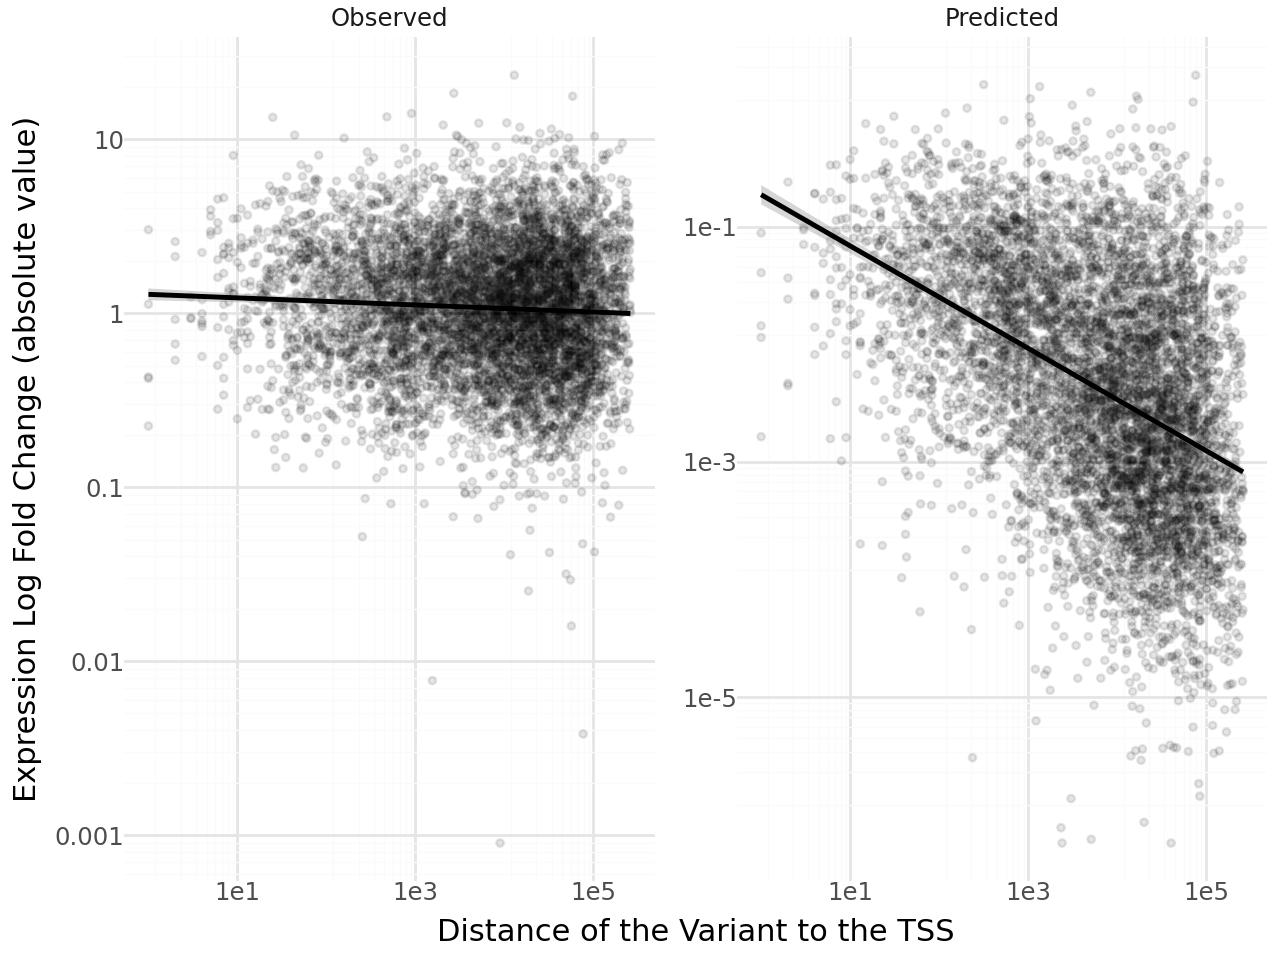

In [22]:
p = (p9.ggplot((all_vars_merged_agg_dedup
            [['variant','gene_id','abs_dist_to_tss','abs_afc','abs_pred_effect']]
            .rename(columns={'abs_afc':'Observed','abs_pred_effect':'Predicted'})
            .melt(id_vars=['variant','gene_id','abs_dist_to_tss'])
           ),
           mapping=p9.aes(x='abs_dist_to_tss+1', y='value/np.log(2)'))#, color='Direction')) 
 + p9.geom_point(alpha=0.1,size=1,raster=True)
 + p9.geom_smooth()
 #+ p9.scale_color_manual(['crimson','steelblue'])
 + p9.scale_y_log10()
 + p9.scale_x_log10()
 + p9.theme_minimal()
 + p9.labs(y='Expression Log Fold Change (absolute value)', x='Distance of the Variant to the TSS')
 + p9.facet_wrap('~variable', scales='free_y')
)

p.save(filename='Graphics/gtex_distance_decay.png', height=4, width=8, dpi=300)

p



In [196]:
all_vars_merged_agg_dedup['dist_to_tss_sign'] = all_vars_merged_agg_dedup['dist_to_tss'] > 0
all_vars_merged_agg_dedup['Direction'] = all_vars_merged_agg_dedup['dist_to_tss_sign'].apply(lambda x: '3-prime' if x else '5-prime')

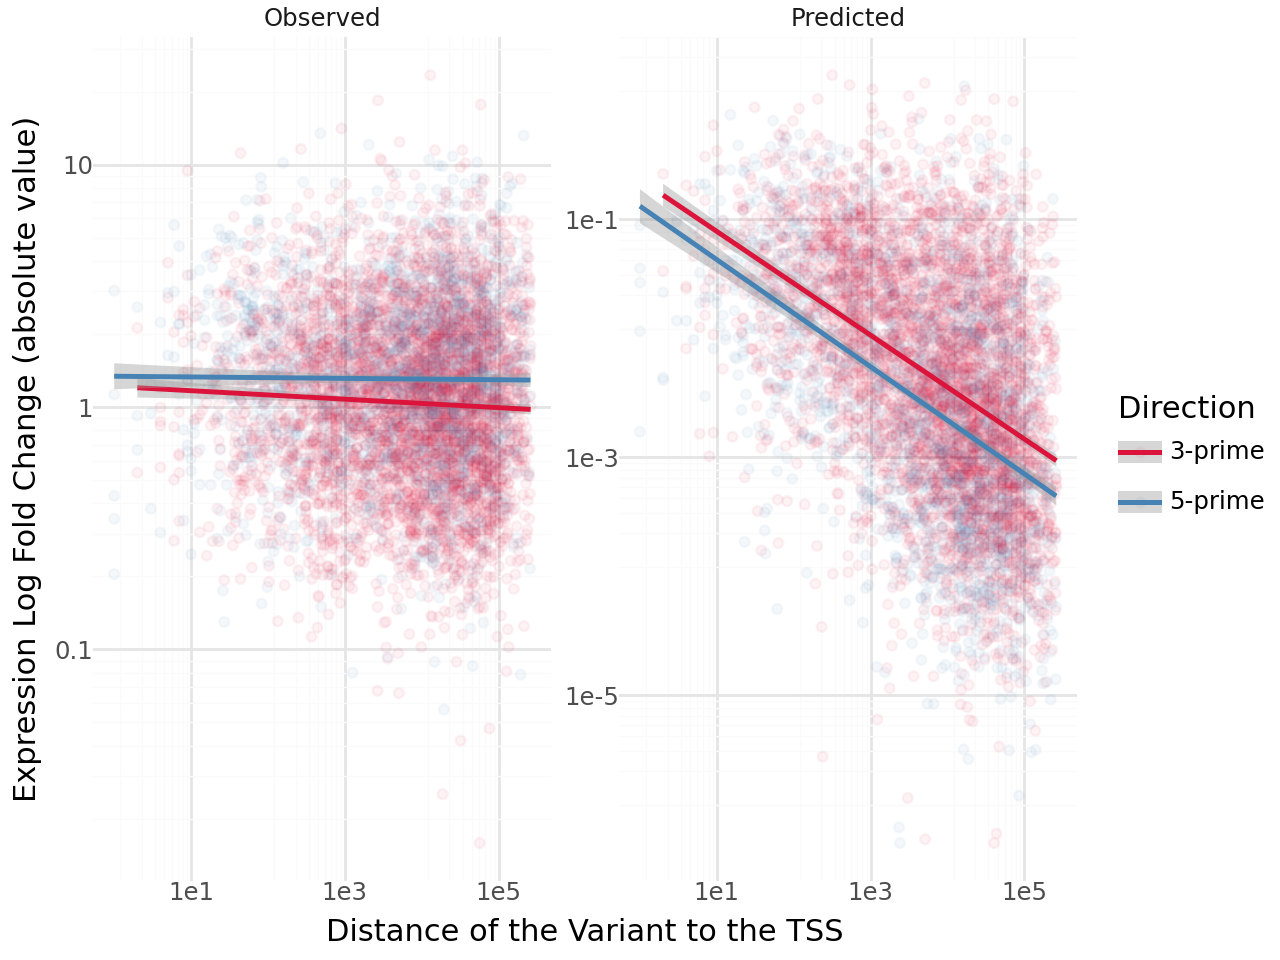

In [198]:
(p9.ggplot((all_vars_merged_agg_dedup
            [['variant','gene_id','abs_dist_to_tss','abs_afc','abs_pred_effect','Direction']]
            .rename(columns={'abs_afc':'Observed','abs_pred_effect':'Predicted'})
            .melt(id_vars=['variant','gene_id','abs_dist_to_tss','Direction'])
           ),
           mapping=p9.aes(x='abs_dist_to_tss+1', y='value/np.log(2)', color='Direction')) 
 + p9.geom_point(alpha=0.05)
 + p9.geom_smooth()
 + p9.scale_color_manual(['crimson','steelblue'])
 + p9.scale_y_log10()
 + p9.scale_x_log10()
 + p9.theme_minimal()
 + p9.labs(y='Expression Log Fold Change (absolute value)', x='Distance of the Variant to the TSS')
 + p9.facet_wrap('~variable', scales='free_y')
)

In [195]:
all_vars_merged_agg_dedup.sort_values('abs_afc')

,variant,gene_id,tissue_label,dist_to_tss,abs_dist_to_tss,beta,slope,afc,pred_effect,abs_afc,abs_slope,abs_beta,abs_pred_effect,tissue_n
8352,chr12_48124481_A_C,ENSG00000177981,heart (left ventricle),56732,56732,0.212463,0.142886,-0.011033,0.000037,0.011033,0.142886,0.212463,0.000037,355
4248,chr19_2016167_A_G,ENSG00000133243,blood,18714,18714,-0.184127,-0.114931,-0.017538,-0.001011,0.017538,0.114931,0.184127,0.001011,588
3359,chrX_47113320_G_A,ENSG00000147123,fibroblast,32184,32184,-0.193149,-0.186076,-0.029194,-0.000168,0.029194,0.186076,0.193149,0.000168,720
1771,chr21_34538997_T_C,ENSG00000159200,brain (cerebellum),76116,76116,0.427119,0.291678,0.032736,-0.000323,0.032736,0.291678,0.427119,0.000323,607
15064,chr1_151235239_C_T,ENSG00000159352,thyroid,-19464,19464,0.288641,0.089309,0.039201,0.000037,0.039201,0.089309,0.288641,0.000037,860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,chr20_15986354_C_A,ENSG00000286546,tibial nerve,-478,478,2.175310,2.180910,9.323936,0.019809,9.323936,2.180910,2.175310,0.019809,909
13897,chr9_114323961_G_A,ENSG00000229314,prostate,905,905,1.477030,1.423560,9.763569,-0.001751,9.763569,1.423560,1.477030,0.001751,233
4706,chr15_100486258_C_T,ENSG00000154227,muscle,58737,58737,-2.042320,-2.085760,-12.256394,-0.005293,12.256394,2.085760,2.042320,0.005293,546
3670,chr1_153110810_A_G,ENSG00000244094,skin,2706,2706,2.094000,2.297290,12.744012,0.000180,12.744012,2.297290,2.094000,0.000180,672


In [156]:
rows = []
for tissue in set(all_vars_merged_agg['tissue_label']):
    sub_df = all_vars_merged_agg.query('tissue_label == @tissue')
    rho_pred_afc = scipy.stats.spearmanr(sub_df['afc'],sub_df['pred_effect'])[0]
    rho_pred_beta = scipy.stats.spearmanr(sub_df['beta'],sub_df['pred_effect'])[0]
    rho_afc_dist = scipy.stats.spearmanr(sub_df['abs_afc'],sub_df['abs_dist_to_tss'])[0]
    rho_pred_dist = scipy.stats.spearmanr(sub_df['abs_pred_effect'],sub_df['abs_dist_to_tss'])[0]
    rho_afc_slope_abs = scipy.stats.spearmanr(sub_df['abs_afc'],sub_df['abs_slope'])[0]
    rho_afc_beta_abs = scipy.stats.spearmanr(sub_df['abs_afc'],sub_df['abs_beta'])[0]
    rho_slope_beta_abs = scipy.stats.spearmanr(sub_df['abs_slope'],sub_df['abs_beta'])[0]
    rows.append({'tissue':tissue,
                 'rho_pred_afc':rho_pred_afc,'rho_pred_beta':rho_pred_beta,
                 'rho_afc_dist':rho_afc_dist,'rho_pred_dist':rho_pred_dist,
                 'rho_afc_slope_abs':rho_afc_slope_abs,
                'rho_afc_beta_abs':rho_afc_beta_abs,
                'rho_slope_beta_abs':rho_slope_beta_abs,
                 'n':len(sub_df)
                })

compare_df = pd.DataFrame(rows)

In [163]:
scipy.stats.wilcoxon(compare_df['rho_pred_afc'], compare_df['rho_pred_beta'])

WilcoxonResult(statistic=123.0, pvalue=2.245167323167152e-07)

In [168]:
scipy.stats.binomtest(41,48)

BinomTestResult(k=41, n=48, alternative='two-sided', statistic=0.8541666666666666, pvalue=6.240408438884516e-07)

In [155]:
pd.DataFrame(rows).sort_values('n',ascending=False)

,tissue,rho_pred_afc,rho_pred_beta,rho_afc_dist,rho_pred_dist,rho_afc_slope_abs,rho_afc_beta_abs,rho_slope_beta_abs,n
40,tibial nerve,0.562753,0.534526,-0.038037,-0.463931,0.722015,0.650287,0.945529,909
25,testis,0.450973,0.432422,-0.149314,-0.417019,0.725658,0.714826,0.900547,888
20,thyroid,0.528421,0.508966,0.010942,-0.532081,0.718355,0.674132,0.962812,860
44,fibroblast,0.578885,0.551251,-0.039867,-0.460824,0.711755,0.672801,0.936017,720
12,adipose,0.575785,0.561129,0.016883,-0.473727,0.736932,0.682847,0.943301,712
26,skin,0.575898,0.544593,-0.037309,-0.529953,0.785431,0.715415,0.946244,672
43,artery (tibial),0.589983,0.557182,-0.049617,-0.490755,0.748625,0.698174,0.953134,657
16,esophagus (muscularis),0.533139,0.510189,0.014340,-0.504936,0.742756,0.697214,0.949766,613
34,brain (cerebellum),0.389230,0.378059,0.017240,-0.493641,0.695276,0.611016,0.925842,607
8,blood,0.579783,0.566364,0.039972,-0.452055,0.802794,0.735254,0.938901,588


In [132]:
len(set(all_vars_merged['variant']))

5705

In [133]:
len(set(all_vars.query('study_label == "GTEx"')['variant']))

9805

In [ ]:
# merge with lead snp allelic fold changes
# deduplicate using strongest study
# ship distance decay plot
# compare 5' and 3' decay

In [561]:
all_vars.query('rep == 0').query('study_label == "GTEx"')['tissue_label'].value_counts()

tissue_label
thyroid                              1520
tibial nerve                         1516
testis                               1348
adipose                              1133
fibroblast                           1100
skin                                 1099
brain (cerebellum)                   1060
artery (tibial)                      1040
esophagus (muscularis)                985
blood                                 908
esophagus (mucosa)                    903
muscle                                872
skin (suprapubic)                     854
lung                                  831
artery (aorta)                        709
adipose (visceral)                    697
spleen                                631
transverse colon                      625
heart (atrial appendage)              623
esophagus (gej)                       612
pancreas                              602
breast                                580
heart (left ventricle)                533
sigmoid colon        

# pQTL

In [45]:
pqtl_df = pd.read_table('Data/pQTL/pqtl.tsv')

In [80]:
rows = []
for _,row in pqtl_df.iterrows():
    trans = row['Cis/trans'] == 'trans'
    beta = row['Beta(cond)']
    lead_rsid = row['rsID']
    variants = row['CS variant IDs'].split(',')
    pips = row['CS PIPs'].split(',')
    gene_name = row['UKBPPP ProteinID'].split(':')
    for i in range(len(variants)):
        rows.append({
            'variant':variants[i],
            'pip':float(pips[i]),
            'trans':trans,
            'beta':beta,
            'lead_rsid':lead_rsid,
            'gene_name':gene_name[0],
        })
pqtl_pip_df = pd.DataFrame(rows)

pqtl_pip_df['Chromosome'] = "chr" + pqtl_pip_df['variant'].str.split(':').str[0].apply(lambda x: str(int(x)) if x not in ["X"," X"] else "X")
pqtl_pip_df['Start'] = pqtl_pip_df['variant'].str.split(':').str[1].astype('int') - 1
pqtl_pip_df['End'] = pqtl_pip_df['variant'].str.split(':').str[1].astype('int')
pqtl_pip_df['Ref'] = pqtl_pip_df['variant'].str.split(':').str[2]
pqtl_pip_df['Alt'] = pqtl_pip_df['variant'].str.split(':').str[3]

pqtl_pip_df = pqtl_pip_df.loc[(pqtl_pip_df['Ref'].str.len() == 1) & (pqtl_pip_df['Alt'].str.len() == 1)]

# remove nonsense and coding overlap
fasta = pyfaidx.Fasta(fasta_file_hg19)

check = pqtl_pip_df.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper() == x['Ref'],axis=1)

pqtl_pip_df = pqtl_pip_df.loc[check]

gtf = pr.read_gtf(gtf_file_hg19)

cds_df = gtf.df.query('Feature == "CDS"')

overlap_df = (pr.PyRanges(pqtl_pip_df[["Chromosome","Start","End","variant"]])
              .join(pr.PyRanges(cds_df),report_overlap=True)
             ).df

pqtl_pip_df_nocoding = pqtl_pip_df.loc[~pqtl_pip_df.variant.isin(overlap_df['variant'])]


/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

In [82]:
check.sum()/len(check)

0.9999942405381641

In [88]:
pqtl_pip_df_nocoding_dedup = pqtl_pip_df_nocoding.sort_values('pip',ascending=False).drop_duplicates('variant').query('pip > 0.9 or pip < 0.01')#.query('not trans')

In [89]:
pqtl_pip_df_nocoding_dedup.query('pip < 0.01')

,variant,pip,trans,beta,lead_rsid,gene_name,Chromosome,Start,End,Ref,Alt
431803,16:88004754:A:G:imp:v1,0.009999,True,0.0364,rs4843746,PRTG,chr16,88004753,88004754,A,G
127546,11:98771391:T:C:imp:v1,0.009999,False,0.0384,rs1487093,CNTN5,chr11,98771390,98771391,T,C
390288,2:206033107:C:T:imp:v1,0.009999,False,0.0518,rs13428191,NRP2,chr2,206033106,206033107,C,T
270151,6:135349570:C:T:imp:v1,0.009999,True,0.0408,rs7742542,ICAM4,chr6,135349569,135349570,C,T
31829,3:178731020:G:A:imp:v1,0.009999,True,-0.0432,rs11428326,ARHGEF10,chr3,178731019,178731020,G,A
...,...,...,...,...,...,...,...,...,...,...,...
441912,6:31358333:C:T:imp:v1,0.000064,True,-0.0331,rs9265649,PTPRB,chr6,31358332,31358333,C,T
441908,6:30204008:T:C:imp:v1,0.000064,True,-0.0331,rs9265649,PTPRB,chr6,30204007,30204008,T,C
441938,6:32209262:T:C:imp:v1,0.000061,True,-0.0331,rs9265649,PTPRB,chr6,32209261,32209262,T,C
295798,6:32394913:G:A:imp:v1,0.000053,True,-0.0280,rs3135382,IL6R,chr6,32394912,32394913,G,A


In [123]:
pqtl_pip_df_nocoding_dedup.to_csv('Data/pQTL/pqtl_dedup_nocoding.tsv',sep="\t",index=None)

In [93]:
pqtl_pip_df_nocoding_dedup[['Chromosome','Start','End','Ref','Alt','variant']].to_csv('Data/pQTL/pqtl_dedup_vars_nocoding.tsv',sep="\t",index=None)

In [137]:
pqtl_pip_df_nocoding_dedup_highpip = pqtl_pip_df_nocoding.query('pip > 0.9').query('not trans').drop_duplicates(subset=['variant','gene_name'])

In [138]:
pqtl_pip_df_nocoding_dedup_highpip[['Chromosome','Start','Ref','Alt','gene_name','variant']].rename(columns={'Start':'Pos'}).to_csv('Data/pQTL/pqtl_dedup_vars_nocoding_highpip.tsv',sep="\t",index=None)

In [190]:
pqtl_pip_df_nocoding_dedup_highpip.drop_duplicates(subset=['variant','gene_name'])

,variant,pip,trans,beta,lead_rsid,gene_name,Chromosome,Start,End,Ref,Alt
30,11:77583379:A:G:imp:v1,1.000000,False,-0.0492,rs148604757,AAMDC,chr11,77583378,77583379,A,G
109,17:41612170:G:A:imp:v1,1.000000,False,-0.0521,rs559305016,AARSD1,chr17,41612169,41612170,G,A
269,9:136149229:T:C:imp:v1,1.000000,False,0.7385,rs505922,ABO,chr9,136149228,136149229,T,C
270,9:136152547:C:T:imp:v1,1.000000,False,-0.0726,rs8176632,ABO,chr9,136152546,136152547,C,T
272,9:136153797:C:T:imp:v1,0.940554,False,0.0422,rs141638449,ABO,chr9,136153796,136153797,C,T
...,...,...,...,...,...,...,...,...,...,...,...
571305,20:56179875:A:G:imp:v1,0.968105,False,0.0336,rs8118279,ZBP1,chr20,56179874,56179875,A,G
571313,11:113953622:G:A:imp:v1,1.000000,False,0.2555,rs73000929,ZBTB16,chr11,113953621,113953622,G,A
571317,11:114087467:C:T:imp:v1,1.000000,False,0.0616,rs397461,ZBTB16,chr11,114087466,114087467,C,T
572510,7:76017997:C:T:imp:v1,1.000000,False,0.7614,rs10281089,ZP3,chr7,76017996,76017997,C,T


## Classification

### Write Config

In [94]:
configs = []
for model in ['flashzoi']:
    for replicate in range(1):
        config = {'name': f'{model}_pQTL_keepscale_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_pQTL_keepscale_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/pQTL/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 120,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/pQTL/pqtl_dedup_vars_nocoding.tsv',
                  'fasta_file': fasta_file_hg19,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'prediction_bin_mode': 'all',
                  'track_subset': 'all',
                  'metric': 'logL2',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

### Run 

In [198]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
Pipe/Configs/flashzoi_pQTL_keepscale_1.txt \
doing_stuff_in_the_arena \
Pipe/job_reports/

Submitted batch job 16618515


### Load Predictions

In [259]:
import warnings

aggs = ['L1','L2','max']
aggs_to_ord = {'L1':1,'L2':2,'max':np.inf}
subsets = ['all','acc','expr','rna','cage']
subset_to_tracks_query = {'all':"RNA:|DNASE:|ATAC:|CHIP:|CAGE:",'acc':"DNASE:|ATAC:",'expr':"RNA:|CAGE:",'rna':"RNA:",'cage':"CAGE:",'chip':"CHIP:"}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rows = []
    df_list = []
    rna_mapping = None
    #cage_mapping = None
    model = 'flashzoi'
    adata_rep_list = []
    for rep in [0]:
        adata_list = []

        autocast = '_noautocast' if (model == "borzoi") else ''
        paths = sorted(glob.glob(f'Results/pQTL/Chunky/{model}_pQTL_keepscale{autocast}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
        for path in tqdm.tqdm(paths):
            adata = ad.read_h5ad(path)
            adata.obs_names = adata.obs['variant']
            adata.obs = adata.obs.drop(columns='variant')
            # aggregate tracks
            metrics = []
            var = []
            for agg in aggs:
                for subset in subsets:
                    metrics.append(np.linalg.norm(adata[:,adata.var.description.str.contains(subset_to_tracks_query[subset])].X, 
                                                  ord=aggs_to_ord[agg], 
                                                  axis=1, 
                                                  keepdims=True))
                    var.append({'metric':agg + "_" + subset})
            #l1_score = np.linalg.norm(adata.X, ord=1, axis=1, keepdims=True)
            #l2_score = np.linalg.norm(adata.X, ord=2, axis=1, keepdims=True)
            #max_score = np.max(adata.X,axis=1, keepdims=True)
            adata = ad.AnnData(X=np.concatenate(metrics,axis=1), 
                               obs=adata.obs.copy(),
                               var=pd.DataFrame(var))
            # add to list
            adata_list.append(adata)
            
        adata = ad.concat(adata_list, merge='same')
        adata = adata[adata.obs_names.sort_values(), :]
        adata_rep_list.append(adata)

    adata = ad.AnnData(np.stack([x.X for x in adata_rep_list]).mean(0), 
                       obs=adata.obs.copy(),
                       var=adata.var.copy())
    

    all_vars = adata.obs.copy()
    metric_names = []
    for agg in aggs:
        for subset in subsets:
            all_vars[f'Borzoi_{agg}_{subset}'] = np.array(adata[:,adata.var.metric == "{}_{}".format(agg,subset)].X[:,0])
            metric_names.append(f'Borzoi_{agg}_{subset}')


00%|██████████| 121/121 [00:39<00:00,  3.10it/s]

### Analyse

#### Overall performance

In [260]:
all_vars_merged = all_vars.reset_index()[['variant']+metric_names].merge(pqtl_pip_df_nocoding_dedup, on='variant')

In [261]:
assert len(all_vars_merged) == len(pqtl_pip_df_nocoding_dedup)

In [262]:
all_vars_merged['label'] = (all_vars_merged['pip'] > 0.9)

In [293]:
rows = []
for metric in metric_names:
    roc = roc_auc_score(all_vars_merged['label'],all_vars_merged[metric])
    ap = average_precision_score(all_vars_merged['label'],all_vars_merged[metric])
    # only cis-eQTL
    roc_cis = roc_auc_score(all_vars_merged.query('not trans')['label'],all_vars_merged.query('not trans')[metric])
    ap_cis = average_precision_score(all_vars_merged.query('not trans')['label'],all_vars_merged.query('not trans')[metric])
    # only trans-eQTL
    roc_trans = roc_auc_score(all_vars_merged.query('trans')['label'],all_vars_merged.query('trans')[metric])
    ap_trans = average_precision_score(all_vars_merged.query('trans')['label'],all_vars_merged.query('trans')[metric])
    rows.append({'metric':metric,'roc':roc,'ap':ap,'roc_cis':roc_cis,'ap_cis':ap_cis,'roc_trans':roc_trans,'ap_trans':ap_trans})

pqtl_metrics = pd.DataFrame(rows)

In [295]:
pqtl_metrics.sort_values('ap_trans',ascending=False)

,metric,roc,ap,roc_cis,ap_cis,roc_trans,ap_trans
13,Borzoi_max_rna,0.701257,0.156248,0.708187,0.310957,0.699351,0.061553
12,Borzoi_max_expr,0.703068,0.155965,0.709844,0.312135,0.703155,0.061307
1,Borzoi_L1_acc,0.691768,0.131519,0.689420,0.277272,0.717439,0.053923
14,Borzoi_max_cage,0.695279,0.141236,0.710064,0.308735,0.705640,0.053740
6,Borzoi_L2_acc,0.682004,0.124914,0.678440,0.264801,0.709152,0.052147
7,Borzoi_L2_expr,0.700977,0.141695,0.707930,0.293861,0.697252,0.049874
11,Borzoi_max_acc,0.669805,0.110621,0.663576,0.239082,0.699634,0.049224
8,Borzoi_L2_rna,0.698744,0.140612,0.705036,0.289560,0.691423,0.048923
2,Borzoi_L1_expr,0.695087,0.131958,0.701664,0.280075,0.691612,0.045035
5,Borzoi_L2_all,0.621585,0.110903,0.620297,0.233868,0.646773,0.044291


In [217]:
all_vars_merged['label'].sum()/len(all_vars_merged)

0.03933575809581387

In [265]:
all_vars_merged.query('not trans')['label'].sum()/len(all_vars_merged.query('not trans'))

0.10586055911081173

In [296]:
all_vars_merged.query('trans')['label'].sum()/len(all_vars_merged.query('trans'))

0.012228428694948053

#### Cis pQTL, control for distance

In [322]:
tss_df = pd.read_table(bed_file_tsscentred_hg19,names=['Chromosome','Start','End','gene_name','strand'])
tss_df['TSS'] = ((tss_df['Start'] + tss_df['End'])/2).astype(int)

In [323]:
all_cis = all_vars_merged.query('not trans')
print(len(all_cis))
all_cis = all_cis.merge(tss_df[['Chromosome','gene_name','TSS']],on=['Chromosome','gene_name'])

29690


In [356]:
all_cis['abs_dist_TSS'] = np.abs(all_cis['TSS'] - all_cis['Start'])
all_cis['abs_dist_TSS_neg'] = -np.abs(all_cis['TSS'] - all_cis['Start'])

In [357]:
# All
all_cis_filtered = all_cis.copy()

print(all_cis_filtered['label'].sum()/len(all_cis_filtered))

rows = []
for metric in metric_names+['abs_dist_TSS_neg']:
    roc = roc_auc_score(all_cis_filtered['label'],all_cis_filtered[metric])
    ap = average_precision_score(all_cis_filtered['label'],all_cis_filtered[metric])
    rows.append({'metric':metric,'roc':roc,'ap':ap})

pqtl_cis_metrics = pd.DataFrame(rows)

0.10607518383616246


In [358]:
# distance dominates
pqtl_cis_metrics.sort_values('ap',ascending=False)

,metric,roc,ap
15,abs_dist_TSS_neg,0.759103,0.378459
12,Borzoi_max_expr,0.711006,0.313147
13,Borzoi_max_rna,0.709892,0.312069
14,Borzoi_max_cage,0.710672,0.309964
9,Borzoi_L2_cage,0.714088,0.296467
7,Borzoi_L2_expr,0.708800,0.294661
8,Borzoi_L2_rna,0.705954,0.290251
2,Borzoi_L1_expr,0.702360,0.280844
1,Borzoi_L1_acc,0.691277,0.280523
4,Borzoi_L1_cage,0.705545,0.279448


In [359]:
# super close
all_cis_filtered = all_cis.query('abs_dist_TSS < 1000')

print(all_cis_filtered['label'].sum()/len(all_cis_filtered))
print(len(all_cis_filtered))

rows = []
for metric in metric_names+['abs_dist_TSS_neg']:
    roc = roc_auc_score(all_cis_filtered['label'],all_cis_filtered[metric])
    ap = average_precision_score(all_cis_filtered['label'],all_cis_filtered[metric])
    rows.append({'metric':metric,'roc':roc,'ap':ap})

pqtl_cis_metrics = pd.DataFrame(rows)

0.7648401826484018
438


In [360]:
pqtl_cis_metrics.sort_values('ap',ascending=False)

,metric,roc,ap
11,Borzoi_max_acc,0.740472,0.905324
10,Borzoi_max_all,0.728271,0.901146
6,Borzoi_L2_acc,0.734647,0.899283
12,Borzoi_max_expr,0.735575,0.898208
13,Borzoi_max_rna,0.732792,0.897156
5,Borzoi_L2_all,0.711636,0.893357
1,Borzoi_L1_acc,0.723721,0.892635
7,Borzoi_L2_expr,0.699464,0.887093
8,Borzoi_L2_rna,0.697841,0.886407
14,Borzoi_max_cage,0.702884,0.884866


In [363]:
# class balanced
all_cis_filtered = all_cis.query('abs_dist_TSS < 6400')

print(all_cis_filtered['label'].sum()/len(all_cis_filtered))
print(len(all_cis_filtered))

rows = []
for metric in metric_names+['abs_dist_TSS_neg']:
    roc = roc_auc_score(all_cis_filtered['label'],all_cis_filtered[metric])
    ap = average_precision_score(all_cis_filtered['label'],all_cis_filtered[metric])
    rows.append({'metric':metric,'roc':roc,'ap':ap})

pqtl_cis_metrics = pd.DataFrame(rows)

0.49969933854479853
1663


In [364]:
pqtl_cis_metrics.sort_values('ap',ascending=False)

,metric,roc,ap
12,Borzoi_max_expr,0.757013,0.774364
13,Borzoi_max_rna,0.754568,0.774232
14,Borzoi_max_cage,0.756552,0.762973
7,Borzoi_L2_expr,0.735234,0.754287
8,Borzoi_L2_rna,0.733698,0.753721
1,Borzoi_L1_acc,0.734037,0.750336
6,Borzoi_L2_acc,0.728361,0.747234
9,Borzoi_L2_cage,0.734375,0.741889
5,Borzoi_L2_all,0.696075,0.734600
2,Borzoi_L1_expr,0.715843,0.733309


In [373]:
# far
all_cis_filtered = all_cis.query('abs_dist_TSS > 10_000')

print(all_cis_filtered['label'].sum()/len(all_cis_filtered))
print(len(all_cis_filtered))

rows = []
for metric in metric_names+['abs_dist_TSS_neg']:
    roc = roc_auc_score(all_cis_filtered['label'],all_cis_filtered[metric])
    ap = average_precision_score(all_cis_filtered['label'],all_cis_filtered[metric])
    rows.append({'metric':metric,'roc':roc,'ap':ap})

pqtl_cis_metrics = pd.DataFrame(rows)

0.07698344482230278
26759


In [374]:
pqtl_cis_metrics.sort_values('ap',ascending=False)

,metric,roc,ap
12,Borzoi_max_expr,0.662703,0.180813
14,Borzoi_max_cage,0.658154,0.180175
13,Borzoi_max_rna,0.659427,0.177502
1,Borzoi_L1_acc,0.645880,0.174388
6,Borzoi_L2_acc,0.635450,0.168532
7,Borzoi_L2_expr,0.659532,0.165294
9,Borzoi_L2_cage,0.663747,0.164076
8,Borzoi_L2_rna,0.655411,0.162560
15,abs_dist_TSS_neg,0.681483,0.158136
2,Borzoi_L1_expr,0.653541,0.156922


#### Cis pQTL, anti-distance benchmark

In [365]:
# collect positive from high distance decreasing
# and negative from low distance increasing
# until we achieve class balance

In [366]:
all_cis_distsort = all_cis.sort_values('abs_dist_TSS')
all_cis_distsort['neg_count'] =(~all_cis_distsort['label']).cumsum()
all_cis_distsort['pos_count'] = (all_cis_distsort.sort_values('abs_dist_TSS',ascending=False)['label']).cumsum()[::-1]

In [367]:
cutpoint = all_cis_distsort.query('pos_count == neg_count')['abs_dist_TSS'].iloc[0]

In [368]:
cutpoint

13562

In [369]:
all_cis_balanced = pd.concat([all_cis_distsort.query('abs_dist_TSS <= @cutpoint and not label'),all_cis_distsort.query('abs_dist_TSS >= @cutpoint and label')])

In [371]:
all_cis_filtered = all_cis_balanced.copy()

print(all_cis_filtered['label'].sum()/len(all_cis_filtered))
print(len(all_cis_filtered))

rows = []
for metric in metric_names+['abs_dist_TSS_neg']:
    roc = roc_auc_score(all_cis_filtered['label'],all_cis_filtered[metric])
    ap = average_precision_score(all_cis_filtered['label'],all_cis_filtered[metric])
    rows.append({'metric':metric,'roc':roc,'ap':ap})

pqtl_cis_metrics = pd.DataFrame(rows)

0.5
3760


In [372]:
pqtl_cis_metrics.sort_values('ap',ascending=False)

,metric,roc,ap
11,Borzoi_max_acc,0.579707,0.608204
6,Borzoi_L2_acc,0.575691,0.605857
1,Borzoi_L1_acc,0.575374,0.603236
10,Borzoi_max_all,0.566122,0.601111
14,Borzoi_max_cage,0.568890,0.583430
12,Borzoi_max_expr,0.567271,0.582768
5,Borzoi_L2_all,0.544805,0.576592
13,Borzoi_max_rna,0.557548,0.575676
0,Borzoi_L1_all,0.538714,0.568175
9,Borzoi_L2_cage,0.548324,0.560928


## Effect Size

### Make bed

In [126]:
gtf_hg19 = pr.read_gtf(gtf_file_hg19).df

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [127]:
gene_gtf = gtf_hg19.query('Feature == "gene"')[['Chromosome','Start','End','gene_name','Strand']]
#gene_gtf['TSS'] = (gene_gtf['Start']*(gene_gtf['Strand']=='+')) + ((gene_gtf['End']-1)*(gene_gtf['Strand']=='-'))
gene_gtf['TSS'] = (gene_gtf['Start']*(gene_gtf['Strand']=='+')) + (gene_gtf['End']*(gene_gtf['Strand']=='-'))
gene_gtf['Start_seq'] = gene_gtf['TSS'] - (6144*32)//2
gene_gtf['End_seq'] = gene_gtf['TSS'] + (6144*32)//2
assert (gene_gtf['End_seq'] - gene_gtf['Start_seq']).min() == (gene_gtf['End_seq'] - gene_gtf['Start_seq']).max()
assert (gene_gtf['End_seq'] - gene_gtf['Start_seq']).min() == 6144*32
gene_gtf = gene_gtf.drop_duplicates(subset = 'gene_name')

In [128]:
gene_gtf[['Chromosome','Start_seq','End_seq','gene_name','Strand']].to_csv(bed_file_tsscentred_hg19,sep="\t",index=None,header=None)

### Write Config

In [129]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_pQTL_tsscentred_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_pQTL_tsscentred_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/pQTL/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariant.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'data_path': f'{base_path}/Data/pQTL/pqtl_dedup_vars_nocoding_highpip.tsv',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file_hg19,
                  'bed_file':bed_file_tsscentred_hg19,
                  'fasta_file': fasta_file_hg19,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'track_subset': 'RNA',
                  'span': False,
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

### Run

In [156]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
Pipe/Configs/flashzoi_pQTL_tsscentred_3.txt \
doing_stuff_in_the_arena \
Pipe/job_reports/

Submitted batch job 16618490


### Analyze

#### Map

#### Load

In [194]:
rows = []
df_list = []
mapping = 'all RNA'#['RNA:blood']
for model in ['flashzoi']:#,'flashzoi']:
    for rep in tqdm.tqdm([0,1,2,3]):
        adata_list = []

        paths = sorted(glob.glob(f'Results/pQTL/Chunky/{model}_pQTL_tsscentred_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
        for path in paths:
            adata = ad.read_h5ad(path)
            if mapping == "all RNA":
                mapping = list(adata.var.loc[adata.var.description.str.startswith('RNA')]['description'])
            adata.obs_names = adata.obs['variant'].astype('str') + adata.obs['gene_name'].astype('str')
            adata_list.append(adata)
        
        adata = ad.concat(adata_list, merge='same')
        
        reduced_df = pqtl_pip_df_nocoding_dedup_highpip.copy()
        reduced_df['unique_id'] =  reduced_df['variant'].astype('str') + reduced_df['gene_name'].astype('str')
        assert len(reduced_df) > 0
    
        reduced_adata = adata[adata.obs.index.isin(set(reduced_df['unique_id'])), adata.var.description.isin(mapping)]
        snp_effects = pd.DataFrame({'variant':reduced_adata.obs['variant'],
                                    'gene_name':reduced_adata.obs['gene_name'],
                                    'unique_id':reduced_adata.obs_names,
                                    'pred_effect':reduced_adata.X.mean(axis=1),
                                    'pred_effect_q1':np.percentile(reduced_adata.X, 25, axis=1),
                                    'pred_effect_q3':np.percentile(reduced_adata.X, 75, axis=1),
                                    'pred_effect_l2':np.linalg.norm(adata.X, ord=2, axis=1),
                                    })
        snp_effects['abs_pred_effect'] = np.abs(snp_effects['pred_effect'])
        snp_effects['pred_effect_upper'] = np.where(np.abs(snp_effects['pred_effect_q3']) >= np.abs(snp_effects['pred_effect_q1']), snp_effects['pred_effect_q3'], snp_effects['pred_effect_q1'])# np.abs(snp_effects['pred_effect'])
        snp_effects['pred_effect_signedL2'] = np.sign(snp_effects['pred_effect']) * snp_effects['pred_effect_l2']
        
        reduced_df = reduced_df.merge(snp_effects, on=['unique_id'])

        reduced_df['model'] = model
        reduced_df['rep'] = rep
        df_list.append(reduced_df)

all_vars = pd.concat(df_list)


00%|██████████| 4/4 [00:01<00:00,  2.30it/s]

In [195]:
for rep in [0,1,2,3]:
    print(len(all_vars.query('rep == @rep')))

2919
2919
2919
2919


In [178]:
all_vars_agg = all_vars.groupby(['variant','gene_name','beta'])[['pred_effect','pred_effect_upper','pred_effect_signedL2']].mean().reset_index()

In [196]:
print(scipy.stats.pearsonr(all_vars_agg['pred_effect_signedL2'],all_vars_agg['beta']))
print(scipy.stats.spearmanr(all_vars_agg['pred_effect_signedL2'],all_vars_agg['beta']))

print(scipy.stats.pearsonr(all_vars.query('rep == 0')['pred_effect_signedL2'],all_vars.query('rep == 0')['beta']))
print(scipy.stats.spearmanr(all_vars.query('rep == 0')['pred_effect_signedL2'],all_vars.query('rep == 0')['beta']))

PearsonRResult(statistic=0.17141431960239056, pvalue=9.574233997191198e-21)
SignificanceResult(statistic=0.25123113490646254, pvalue=2.198574369235548e-43)
PearsonRResult(statistic=0.17451786535940012, pvalue=2.144847297642004e-21)
SignificanceResult(statistic=0.250219906221308, pvalue=6.526693791867238e-43)


In [197]:
print(scipy.stats.pearsonr(all_vars_agg['pred_effect'],all_vars_agg['beta']))
print(scipy.stats.spearmanr(all_vars_agg['pred_effect'],all_vars_agg['beta']))

print(scipy.stats.pearsonr(all_vars.query('rep == 0')['pred_effect'],all_vars.query('rep == 0')['beta']))
print(scipy.stats.spearmanr(all_vars.query('rep == 0')['pred_effect'],all_vars.query('rep == 0')['beta']))

PearsonRResult(statistic=0.1548801286287315, pvalue=3.514969425924948e-17)
SignificanceResult(statistic=0.25450048718258034, pvalue=1.6378923472790655e-44)
PearsonRResult(statistic=0.15805687247757919, pvalue=8.70840781524278e-18)
SignificanceResult(statistic=0.25438384700363204, pvalue=2.433396477269544e-44)


# GWAS

In [55]:
gwas_ukbb = pd.read_table('Data/GWAS/UKBB_94traits_release1.1/release1.1/UKBB_94traits_release1.bed',names=['Chromosome','Start','End','variant','rsID','Ref','Alt','minorallele','cohort',
                                                                                                            'model_marginal','method','trait','region','maf','beta_marginal','se_marginal',
                                                                                                            'chisq_marginal','pip','cs_id','beta_posterior','sd_posterior','LD_HWE','LD_SV'])

gwas_ukbb = gwas_ukbb.loc[(gwas_ukbb['Ref'].str.len() == 1) & (gwas_ukbb['Alt'].str.len() == 1)]

gwas_ukbb_dedup = gwas_ukbb.sort_values('pip', ascending=False).drop_duplicates(subset='variant')

gwas_ukbb_dedup = gwas_ukbb_dedup.query('pip > 0.9 or pip < 0.01')

gwas_ukbb_dedup['Ref'] = gwas_ukbb_dedup['variant'].str.split(':').str[2]
gwas_ukbb_dedup['Alt'] = gwas_ukbb_dedup['variant'].str.split(':').str[3]
gwas_ukbb_dedup['Start'] = gwas_ukbb_dedup['Start'].astype('int')

fasta = pyfaidx.Fasta(fasta_file_hg19)

check = gwas_ukbb_dedup.progress_apply(lambda x: str(fasta[x['Chromosome']][x['Start']]).upper() == x['Ref'],axis=1)

gwas_ukbb_dedup = gwas_ukbb_dedup.loc[check]

gtf = pr.read_gtf(gtf_file_hg19)

cds_df = gtf.df.query('Feature == "CDS"')

overlap_df = (pr.PyRanges(gwas_ukbb_dedup[["Chromosome","Start","End","variant"]])
              .join(pr.PyRanges(cds_df),report_overlap=True)
             ).df

gwas_ukbb_dedup_nocoding = gwas_ukbb_dedup.loc[~gwas_ukbb_dedup.variant.isin(overlap_df['variant'])]


/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

In [56]:
len(gwas_ukbb_dedup_nocoding)

1396164

In [61]:
gwas_ukbb_dedup_nocoding['End'] = gwas_ukbb_dedup_nocoding['End'].astype('int')
gwas_ukbb_dedup_nocoding[['Chromosome','Start','End','Ref','Alt','variant']].to_csv('Data/GWAS/gwas_dedup_vars_nocoding.tsv',sep="\t",index=None)#['variant'].drop_duplicates()

In [67]:
gwas_ukbb_dedup_nocoding.to_csv('Data/GWAS/gwas_dedup_nocoding.tsv',sep="\t",index=None)

In [62]:
gwas_ukbb_dedup_nocoding = pd.read_csv('Data/GWAS/gwas_dedup_nocoding.tsv',sep="\t")

## Write Config

In [39]:
configs = []
for model in ['flashzoi']:
    for replicate in range(1):
        config = {'name': f'{model}_GWAS_keepscale_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_GWAS_keepscale_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/GWAS/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 120,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/GWAS/gwas_dedup_vars_nocoding.tsv',
                  'fasta_file': fasta_file_hg19,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'prediction_bin_mode': 'all',
                  'track_subset': 'all',
                  'metric': 'logL2',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run 

In [43]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
Pipe/Configs/flashzoi_GWAS_keepscale_0.txt \
doing_stuff_in_the_arena \
Pipe/job_reports/

Submitted batch job 16617233


## Load Predictions

In [66]:
import warnings

aggs = ['L1','L2','max']
aggs_to_ord = {'L1':1,'L2':2,'max':np.inf}
subsets = ['all','acc','expr','rna','cage']
subset_to_tracks_query = {'all':"RNA:|DNASE:|ATAC:|CHIP:|CAGE:",'acc':"DNASE:|ATAC:",'expr':"RNA:|CAGE:",'rna':"RNA:",'cage':"CAGE:",'chip':"CHIP:"}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rows = []
    df_list = []
    rna_mapping = None
    #cage_mapping = None
    model = 'flashzoi'
    adata_rep_list = []
    for rep in [0]:
        adata_list = []

        autocast = '_noautocast' if (model == "borzoi") else ''
        paths = sorted(glob.glob(f'Results/GWAS/Chunky/{model}_GWAS_keepscale{autocast}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
        for path in tqdm.tqdm(paths):
            adata = ad.read_h5ad(path)
            adata.obs_names = adata.obs['variant']
            adata.obs = adata.obs.drop(columns='variant')
            # aggregate tracks
            metrics = []
            var = []
            for agg in aggs:
                for subset in subsets:
                    metrics.append(np.linalg.norm(adata[:,adata.var.description.str.contains(subset_to_tracks_query[subset])].X, 
                                                  ord=aggs_to_ord[agg], 
                                                  axis=1, 
                                                  keepdims=True))
                    var.append({'metric':agg + "_" + subset})
            adata = ad.AnnData(X=np.concatenate(metrics,axis=1), 
                               obs=adata.obs.copy(),
                               var=pd.DataFrame(var))
            # add to list
            adata_list.append(adata)
            
        adata = ad.concat(adata_list, merge='same')
        adata = adata[adata.obs_names.sort_values(), :]
        adata_rep_list.append(adata)

    adata = ad.AnnData(np.stack([x.X for x in adata_rep_list]).mean(0), 
                       obs=adata.obs.copy(),
                       var=adata.var.copy())
    

    all_vars = adata.obs.copy()
    metric_names = []
    for agg in aggs:
        for subset in subsets:
            all_vars[f'Borzoi_{agg}_{subset}'] = np.array(adata[:,adata.var.metric == "{}_{}".format(agg,subset)].X[:,0])
            metric_names.append(f'Borzoi_{agg}_{subset}')


00%|██████████| 121/121 [07:23<00:00,  3.66s/it]

In [68]:
all_vars_merged = all_vars.reset_index()[['variant']+metric_names].merge(gwas_ukbb_dedup_nocoding, on='variant')

In [69]:
assert len(all_vars_merged) == len(gwas_ukbb_dedup_nocoding)

In [70]:
all_vars_merged['label'] = (all_vars_merged['pip'] > 0.9)

In [71]:
print(roc_auc_score(all_vars_merged['label'],all_vars_merged['Borzoi_L2']))
print(average_precision_score(all_vars_merged['label'],all_vars_merged['Borzoi_L2']))

0.6404246667553348
0.0062727095745281364


In [72]:
all_vars_merged['label'].sum()/len(all_vars_merged)

0.001768416890852364

# OMIM

In [97]:
omim_df = pd.read_csv('Data/GWAS/omim.tsv',sep='\t')

/scratch/tmp/karollus/ipykernel_1549821/3082732238.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


In [98]:
omim_df

,Chromosome,Pos,Ref,Alt,label,consequence,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-100v,NT
0,1,13273,G,C,False,ncRNA,-4.074219,-0.398596,-1.091,-0.864,-1.000,0.114410
1,1,14464,A,T,False,ncRNA,0.895020,0.339809,1.705,-0.992,-0.000,-0.155609
2,1,16688,G,A,False,ncRNA,-4.027344,-1.448712,-3.121,-1.305,-0.996,-1.577560
3,1,17697,G,C,False,ncRNA,-4.734375,-1.043489,-2.491,-8.751,-1.000,0.863495
4,1,49554,A,G,False,Enhancer,-1.988281,-0.227302,-0.024,0.078,-0.003,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2640667,Y,22315655,C,T,False,ncRNA,-0.125977,-0.187737,-0.055,-0.120,-0.015,-3.147705
2640668,Y,22315970,T,C,False,ncRNA,-0.430664,-0.242270,-0.000,-0.000,-0.018,-1.585403
2640669,Y,22332256,A,G,False,ncRNA,-1.598633,-0.287136,-0.061,-0.095,-0.010,-3.090973
2640670,Y,22353396,C,T,False,Enhancer,-1.453125,-0.233249,-0.398,-0.120,-0.002,NaN


In [99]:
omim_df['Chromosome'] = 'chr' + omim_df['Chromosome'].astype('str')
omim_df['End'] = omim_df['Pos']
omim_df['Start'] = omim_df['End'] - 1

In [100]:
omim_df['variant'] = omim_df['Chromosome'] + "_" + omim_df['Start'].astype('str') + "_" + omim_df['Alt']

In [93]:
omim_df[['Chromosome','Start','End','Ref', 'Alt','variant']].to_csv('Data/GWAS/omim_all_vars.tsv',sep="\t", index=None)

## Write Config

In [564]:
configs = []
for model in ['flashzoi']:
    for replicate in range(4):
        config = {
                  'name': f'{model}_omim_keepscale_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_omim_keepscale_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/GWAS/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 300,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/GWAS/omim_all_vars.tsv',
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'prediction_bin_mode': 'all',
                  'track_subset': 'all',
                  'metric': 'logL2',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run 

In [13]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/flashzoi_omim_keepscale_2.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

Submitted batch job 16613845


## Load Predictions

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rows = []
    df_list = []
    rna_mapping = None
    #cage_mapping = None
    model = 'flashzoi'
    adata_rep_list = []
    for rep in [0]:
        adata_list = []

        autocast = '_noautocast' if (model == "borzoi") else ''
        paths = sorted(glob.glob(f'Results/GWAS/Chunky/{model}_omim_keepscale{autocast}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
        for path in tqdm.tqdm(paths):
            adata = ad.read_h5ad(path)
            adata.obs_names = adata.obs['variant']
            adata.obs = adata.obs.drop(columns='variant')
            # aggregate tracks
            l1_score = np.linalg.norm(adata.X, ord=1, axis=1, keepdims=True)
            l2_score = np.linalg.norm(adata.X, ord=2, axis=1, keepdims=True)
            max_score = np.max(adata.X,axis=1, keepdims=True)
            adata = ad.AnnData(X=np.concatenate([l1_score,l2_score,max_score],axis=1), 
                               obs=adata.obs.copy(),
                               var=pd.DataFrame([{'metric':'l1'},{'metric':'l2'},{'metric':'max'}]))
            # add to list
            adata_list.append(adata)
            
        adata = ad.concat(adata_list, merge='same')
        adata = adata[adata.obs_names.sort_values(), :]
        adata_rep_list.append(adata)

    adata = ad.AnnData(np.stack([x.X for x in adata_rep_list]).mean(0), 
                       obs=adata.obs.copy(),
                       var=adata.var.copy())
    

    all_vars = adata.obs.copy() 
    all_vars['Borzoi'] = np.array(adata.X[:,0])
    all_vars['Borzoi_L2'] = np.array(adata.X[:,1])
    all_vars['Borzoi_max'] = np.array(adata.X[:,2])
    
    assert len(all_vars) == len(omim_df)

  7%|▋         | 21/301 [01:06<15:19,  3.29s/it]

In [104]:
omim_merged = all_vars[['Borzoi','Borzoi_L2','Borzoi_max']].reset_index().merge(omim_df,on='variant')

assert set(omim_merged['variant']) == set(omim_df['variant'])
assert len(omim_df) == len(omim_merged)

In [105]:
print(roc_auc_score(omim_merged['label'],omim_merged['Borzoi_L2']))
print(average_precision_score(omim_merged['label'],omim_merged['Borzoi_L2']))

0.8939533163696498
0.05169428005463674


In [106]:
print(roc_auc_score(omim_merged['label'],-omim_merged['GPN-MSA']))
print(average_precision_score(omim_merged['label'],-omim_merged['GPN-MSA']))

0.9311486160938724
0.12692325943228383


In [111]:
rows = []
for consequence in set(omim_merged['consequence']):
    sub_df = omim_merged.query('consequence == @consequence')
    ap_borzoi = average_precision_score(sub_df['label'],sub_df['Borzoi_L2'])
    ap_gpn = average_precision_score(sub_df['label'],-sub_df['GPN-MSA'])
    rows.append({'consequence':consequence, 'ap_borzoi':ap_borzoi, 'ap_gpn':ap_gpn})

pd.DataFrame(rows)

,consequence,ap_borzoi,ap_gpn
0,3' UTR,0.023173,0.044188
1,5' UTR,0.101031,0.330862
2,Promoter,0.235108,0.264648
3,MicroRNA Gene,1.000000,1.000000
4,Enhancer,0.004283,0.069788
5,ncRNA,0.001687,0.101792
6,Imprinting Control Region,1.000000,1.000000


In [112]:
print(roc_auc_score(omim_merged.query('consequence in ["Promoter","Enhancer"]')['label'],
                    omim_merged.query('consequence in ["Promoter","Enhancer"]')['Borzoi_L2']))
print(average_precision_score(omim_merged.query('consequence in ["Promoter","Enhancer"]')['label'],
                              omim_merged.query('consequence in ["Promoter","Enhancer"]')['Borzoi_L2']))

0.9222236418867272
0.08748550554015005


In [113]:
print(roc_auc_score(omim_merged.query('consequence in ["Promoter","Enhancer"]')['label'],
                    -omim_merged.query('consequence in ["Promoter","Enhancer"]')['GPN-MSA']))
print(average_precision_score(omim_merged.query('consequence in ["Promoter","Enhancer"]')['label'],
                              -omim_merged.query('consequence in ["Promoter","Enhancer"]')['GPN-MSA']))

0.9380455495508238
0.07301177117824353


# FlowFish

In [5]:
varflowfish = pd.read_table('Data/VariantFlowfish/flowfish_ppif.tsv')
varflowfish['Chromosome'] = varflowfish['VariantID'].apply(lambda x: x.split(':')[0])
varflowfish['Pos_hg19'] = varflowfish['VariantID'].apply(lambda x: int(x.split(':')[1]))
varflowfish['Ref'] = varflowfish['VariantID'].apply(lambda x: x.split(':')[2].split('>')[0])
varflowfish['Alt'] = varflowfish['VariantID'].apply(lambda x: x.split(':')[2].split('>')[1])
varflowfish = varflowfish.loc[varflowfish['Ref'].str.len() == varflowfish['Alt'].str.len()]
varflowfish['coordinate_hg19'] = varflowfish['Chromosome'] + ":" + varflowfish['Pos_hg19'].astype(str) + "-" + (varflowfish['Pos_hg19'] + varflowfish['Ref'].str.len()).astype(str)

In [8]:
varflowfish['coordinate'] = pd.read_table('Data/VariantFlowfish/hglft_genome_2c27a_a6e70.bed',header=None)[0]
varflowfish['Pos'] = varflowfish['coordinate'].apply(lambda x: int(x.split(':')[1].split('-')[0]))
varflowfish['gene_name'] = "PPIF"

In [9]:
varflowfish[['Chromosome','Pos','Ref','Alt','gene_name','VariantID','% change to PPIF expression','95% confidence interval','corrected p value']].to_csv('Data/VariantFlowfish/flowfish_ppif_remapped_noindel.tsv',sep="\t",index=None)

In [57]:
varflowfish

,n,Screen,VariantID,% change to PPIF expression,95% confidence interval,corrected p value,Enformer CAGE,Enformer DNase,ProCapNet PRO-cap,ChromBPNet ATAC,...,coordinate,Pos,gene_name,borzoi_0_pred,borzoi_1_pred,borzoi_2_pred,borzoi_3_pred,borzoi_pred,Promoter,% change Borzoi
0,1,PPIF Enhancer Tiling Mutagenesis,chr10:81046461:GGACA>TTGGG,32.695934,3.868924,0.000025,43.51,6.40,-4.12,39.86,...,chr10:79286704-79286709,79286704,PPIF,0.006192,0.007685,0.011445,-0.000760,0.006141,False,0.615942
1,2,PPIF Enhancer Tiling Mutagenesis,chr10:81046396:GGCAG>TCGGT,16.290425,9.507436,0.028945,-1.90,-2.48,0.90,-4.33,...,chr10:79286639-79286644,79286639,PPIF,0.001196,-0.000596,-0.001283,0.000731,0.000012,False,0.001180
2,3,PPIF Enhancer Tiling Mutagenesis,chr10:81046541:CCTGT>GGGAA,15.075833,1.760569,0.000025,21.42,17.82,12.67,68.24,...,chr10:79286784-79286789,79286784,PPIF,0.016268,0.026843,0.014215,0.002481,0.014952,False,1.506412
3,4,PPIF Enhancer Tiling Mutagenesis,chr10:81046416:GGGAA>CAGTC,12.738096,2.604852,0.000462,20.38,5.43,4.60,11.56,...,chr10:79286659-79286664,79286659,PPIF,0.002745,0.011264,0.003928,0.002330,0.005067,False,0.507963
4,5,PPIF Enhancer Tiling Mutagenesis,chr10:81046551:GTCCT>GAGGC,12.415394,9.672105,0.075477,11.11,5.21,4.18,13.98,...,chr10:79286794-79286799,79286794,PPIF,0.003800,0.004323,0.001299,0.000586,0.002502,False,0.250494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,PPIF Promoter Tiling Mutagenesis,chr10:81107226:TCGGC>AGCCA,0.009890,8.720497,0.998288,1.87,0.79,-2.75,7.34,...,chr10:79347470-79347475,79347470,PPIF,-0.046704,0.006771,0.036896,0.028284,0.006312,True,0.633168
176,177,PPIF Promoter Tiling Mutagenesis,chr10:81107231:CTTCT>AACCC,-6.723477,4.832020,0.053899,-1.55,-3.41,-7.65,-5.73,...,chr10:79347475-79347480,79347475,PPIF,-0.029745,-0.037278,-0.015835,-0.030519,-0.028344,True,-2.794635
177,178,PPIF Promoter Tiling Mutagenesis,chr10:81107231:CTTCT>GCAGC,9.844215,10.782774,0.170077,-19.76,-16.80,-1.95,-5.03,...,chr10:79347475-79347480,79347475,PPIF,-0.022707,0.001535,0.009648,-0.012452,-0.005994,True,-0.597590
178,179,PPIF Promoter Tiling Mutagenesis,chr10:81107236:GGGCG>CCCTT,-13.579949,2.864821,0.000229,2.22,0.44,-8.19,-1.37,...,chr10:79347480-79347485,79347480,PPIF,0.005447,0.039904,-0.008070,0.015272,0.013138,True,1.322496


## Write config

In [11]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_flowfish_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_flowfish_{replicate}.txt',
                  'replicate': 0,
                  'projectfolder': f'{base_path}/Results/VariantFlowfish/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariant.py',
                  'num_of_jobs': 1,
                  'conda': 'scooby_package',
                  'data_path': f'{base_path}/Data/VariantFlowfish/flowfish_ppif_remapped_noindel.tsv',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'bed_file':bed_file_tsscentred,
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep_track_scales',
                  'track_subset': 'RNA',
                  'span': False,
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run

In [12]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/borzoi_flowfish_0.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

Submitted batch job 16613842


## Plot

In [47]:
rows = []
df_list = []
mapping = None
for model in ['borzoi']:
    rep_list = []
    for rep in [0,1,2,3]:
        adata_list = []

        autocast = "_noautocast" if model == "borzoi" else ""
        paths = sorted(glob.glob(f'Results/VariantFlowfish/Chunky/{model}_flowfish{autocast}_{rep}/*.h5ad'),key=lambda x: int(x.split('/')[-1].split('_')[1]))
        for path in paths:
            adata = ad.read_h5ad(path)
            adata_list.append(adata)
        
        adata = ad.concat(adata_list, merge='same')
        assert all([x == y for x,y in zip(adata.obs.VariantID,varflowfish.VariantID)])
        varflowfish[f'{model}_{rep}_pred'] = adata.X[:,np.array(adata.var.loc[adata.var.description.str.contains('monocyte',case=False)].index).astype(int)].mean(axis=-1)
        #varflowfish[f'{model}_{rep}_pred'] = adata.X[:,np.array(adata.var.loc[adata.var.description.isin(['RNA:CD14-positive monocyte'])].index).astype(int)].mean(axis=-1)
        rep_list.append(adata)
    mean = np.stack([np.array(varflowfish[f'{model}_{rep}_pred']) for rep in range(4)]).mean(axis=0)
    varflowfish[f'{model}_pred'] = mean

In [92]:
varflowfish['Promoter'] = varflowfish['Screen'].str.contains('Promoter')
varflowfish['ElementType'] = varflowfish['Promoter'].apply(lambda x: 'Promoter' if x else 'Enhancer')
varflowfish['maxObs'] = varflowfish['% change to PPIF expression'] + varflowfish['95% confidence interval']
varflowfish['minObs'] = varflowfish['% change to PPIF expression'] - varflowfish['95% confidence interval']

In [93]:
varflowfish['% change Borzoi'] = ((np.exp(varflowfish['borzoi_pred'])) - 1)*100

In [59]:
varflowfish

,n,Screen,VariantID,% change to PPIF expression,95% confidence interval,corrected p value,Enformer CAGE,Enformer DNase,ProCapNet PRO-cap,ChromBPNet ATAC,...,Pos,gene_name,borzoi_0_pred,borzoi_1_pred,borzoi_2_pred,borzoi_3_pred,borzoi_pred,Promoter,% change Borzoi,ElementType
0,1,PPIF Enhancer Tiling Mutagenesis,chr10:81046461:GGACA>TTGGG,32.695934,3.868924,0.000025,43.51,6.40,-4.12,39.86,...,79286704,PPIF,0.006192,0.007685,0.011445,-0.000760,0.006141,False,0.615942,Enhancer
1,2,PPIF Enhancer Tiling Mutagenesis,chr10:81046396:GGCAG>TCGGT,16.290425,9.507436,0.028945,-1.90,-2.48,0.90,-4.33,...,79286639,PPIF,0.001196,-0.000596,-0.001283,0.000731,0.000012,False,0.001180,Enhancer
2,3,PPIF Enhancer Tiling Mutagenesis,chr10:81046541:CCTGT>GGGAA,15.075833,1.760569,0.000025,21.42,17.82,12.67,68.24,...,79286784,PPIF,0.016268,0.026843,0.014215,0.002481,0.014952,False,1.506412,Enhancer
3,4,PPIF Enhancer Tiling Mutagenesis,chr10:81046416:GGGAA>CAGTC,12.738096,2.604852,0.000462,20.38,5.43,4.60,11.56,...,79286659,PPIF,0.002745,0.011264,0.003928,0.002330,0.005067,False,0.507963,Enhancer
4,5,PPIF Enhancer Tiling Mutagenesis,chr10:81046551:GTCCT>GAGGC,12.415394,9.672105,0.075477,11.11,5.21,4.18,13.98,...,79286794,PPIF,0.003800,0.004323,0.001299,0.000586,0.002502,False,0.250494,Enhancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,PPIF Promoter Tiling Mutagenesis,chr10:81107226:TCGGC>AGCCA,0.009890,8.720497,0.998288,1.87,0.79,-2.75,7.34,...,79347470,PPIF,-0.046704,0.006771,0.036896,0.028284,0.006312,True,0.633168,Promoter
176,177,PPIF Promoter Tiling Mutagenesis,chr10:81107231:CTTCT>AACCC,-6.723477,4.832020,0.053899,-1.55,-3.41,-7.65,-5.73,...,79347475,PPIF,-0.029745,-0.037278,-0.015835,-0.030519,-0.028344,True,-2.794635,Promoter
177,178,PPIF Promoter Tiling Mutagenesis,chr10:81107231:CTTCT>GCAGC,9.844215,10.782774,0.170077,-19.76,-16.80,-1.95,-5.03,...,79347475,PPIF,-0.022707,0.001535,0.009648,-0.012452,-0.005994,True,-0.597590,Promoter
178,179,PPIF Promoter Tiling Mutagenesis,chr10:81107236:GGGCG>CCCTT,-13.579949,2.864821,0.000229,2.22,0.44,-8.19,-1.37,...,79347480,PPIF,0.005447,0.039904,-0.008070,0.015272,0.013138,True,1.322496,Promoter


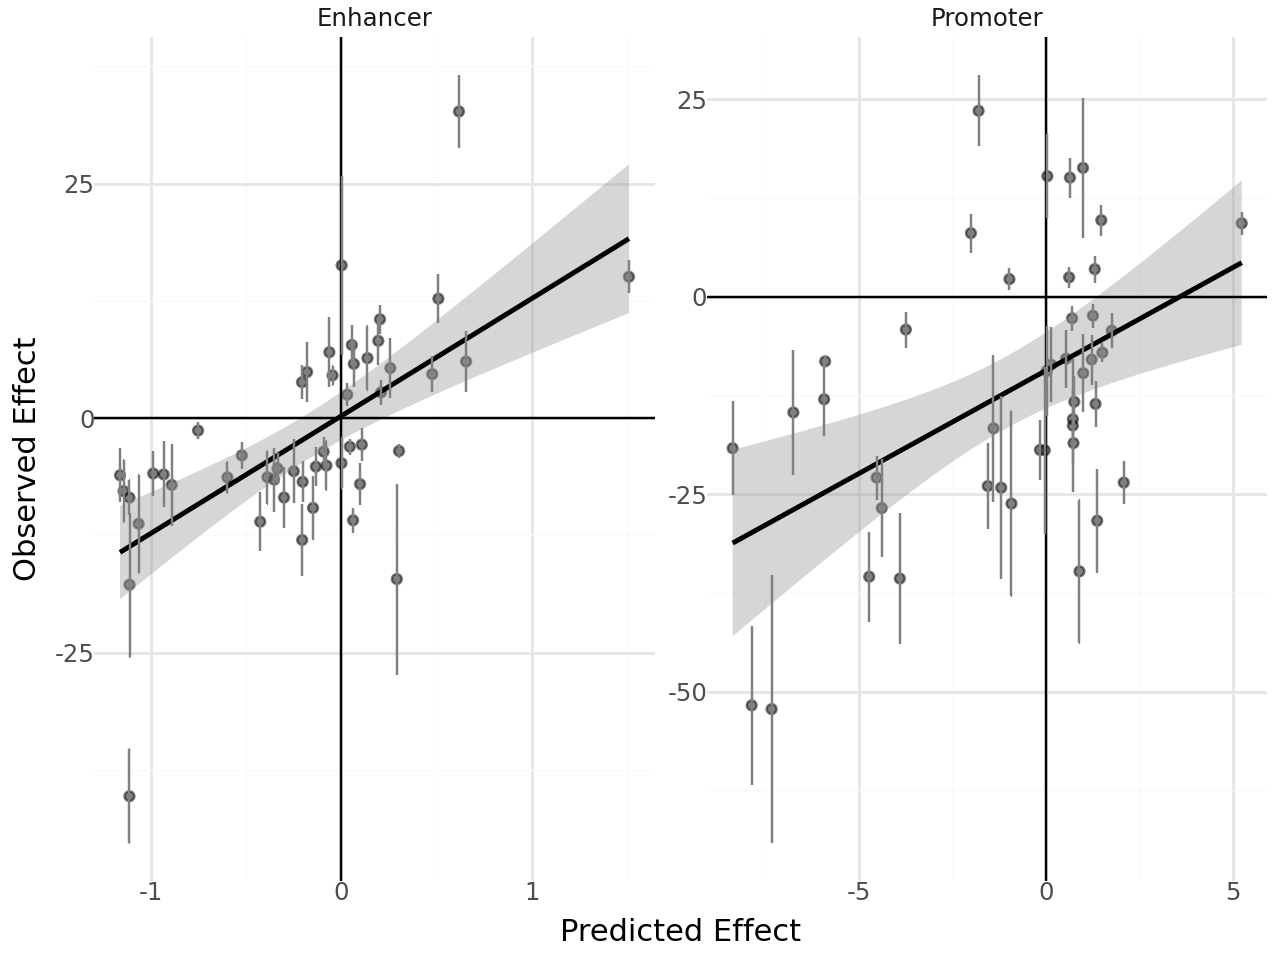

In [86]:
(p9.ggplot(varflowfish.loc[varflowfish['corrected p value'] < 0.05], 
           mapping=p9.aes(x='% change Borzoi',y='% change to PPIF expression')) 
 + p9.geom_point(alpha=0.5)
 + p9.geom_smooth(method='lm')
 #+ p9.scale_y_log10()
 #+ p9.scale_x_log10()
 + p9.geom_hline(yintercept=0)
 + p9.geom_vline(xintercept=0)
 + p9.geom_errorbar(mapping=p9.aes(ymin='minObs',ymax='maxObs'),width=0.001,color='grey')
 + p9.theme_minimal()
 + p9.labs(y='Observed Effect', x='Predicted Effect')
 + p9.facet_wrap('ElementType',scales='free')
)

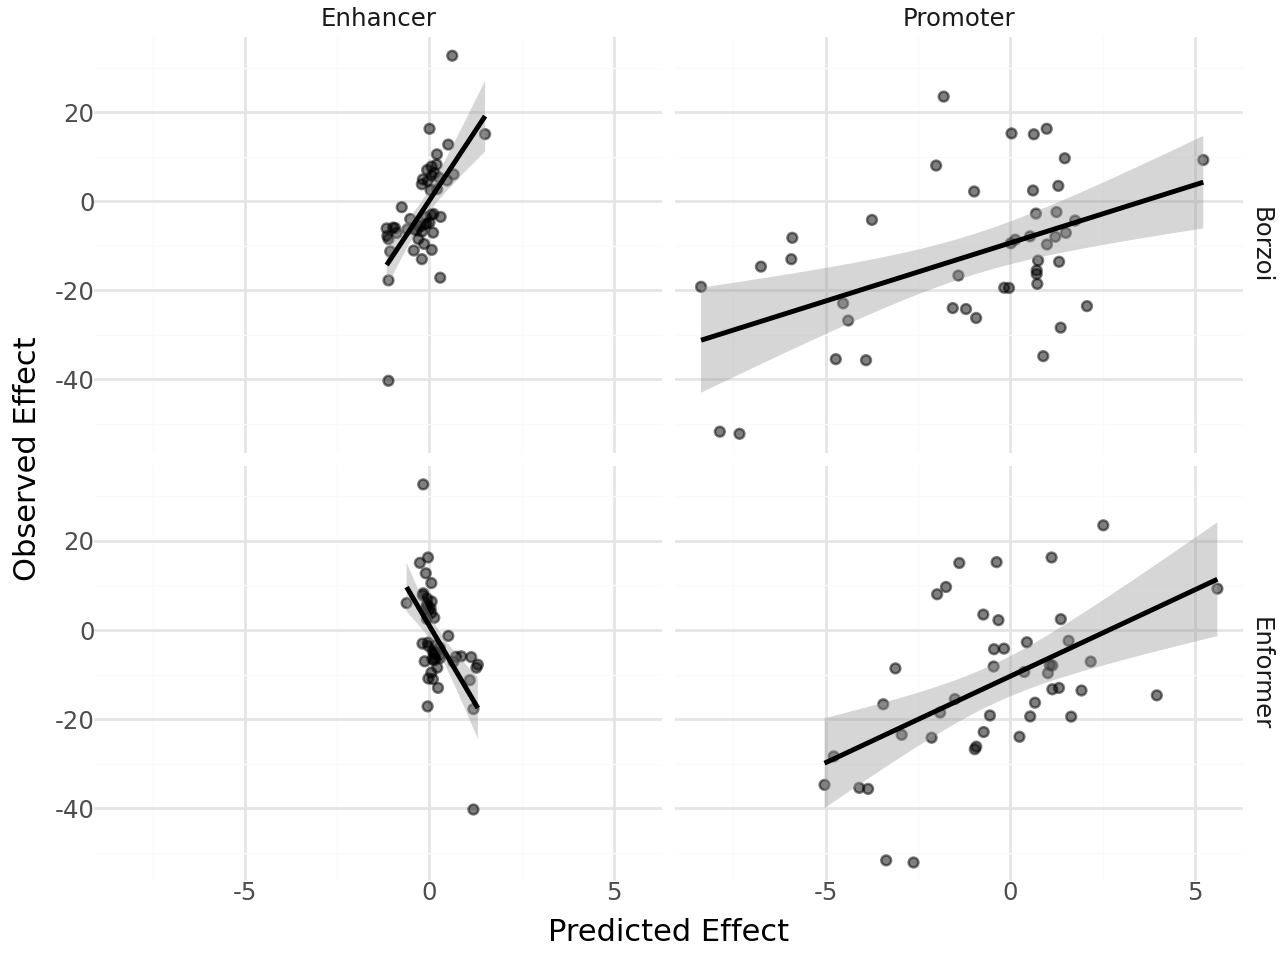

In [68]:
(p9.ggplot((varflowfish.loc[varflowfish['corrected p value'] < 0.05]
            [['ElementType','VariantID','% change to PPIF expression','% change Borzoi','Enformer CAGE TSS']]
            .rename(columns={'% change Borzoi':'Borzoi','Enformer CAGE TSS':'Enformer'})
            .melt(id_vars=['ElementType','VariantID','% change to PPIF expression'])
           )
           , 
           mapping=p9.aes(x='value',y='% change to PPIF expression')) 
 + p9.geom_point(alpha=0.5)
 + p9.geom_smooth(method='lm')
 #+ p9.scale_y_log10()
 #+ p9.scale_x_log10()
 + p9.theme_minimal()
 + p9.labs(y='Observed Effect', x='Predicted Effect')
 + p9.facet_grid('variable~ElementType')#,scales='free_x')
)

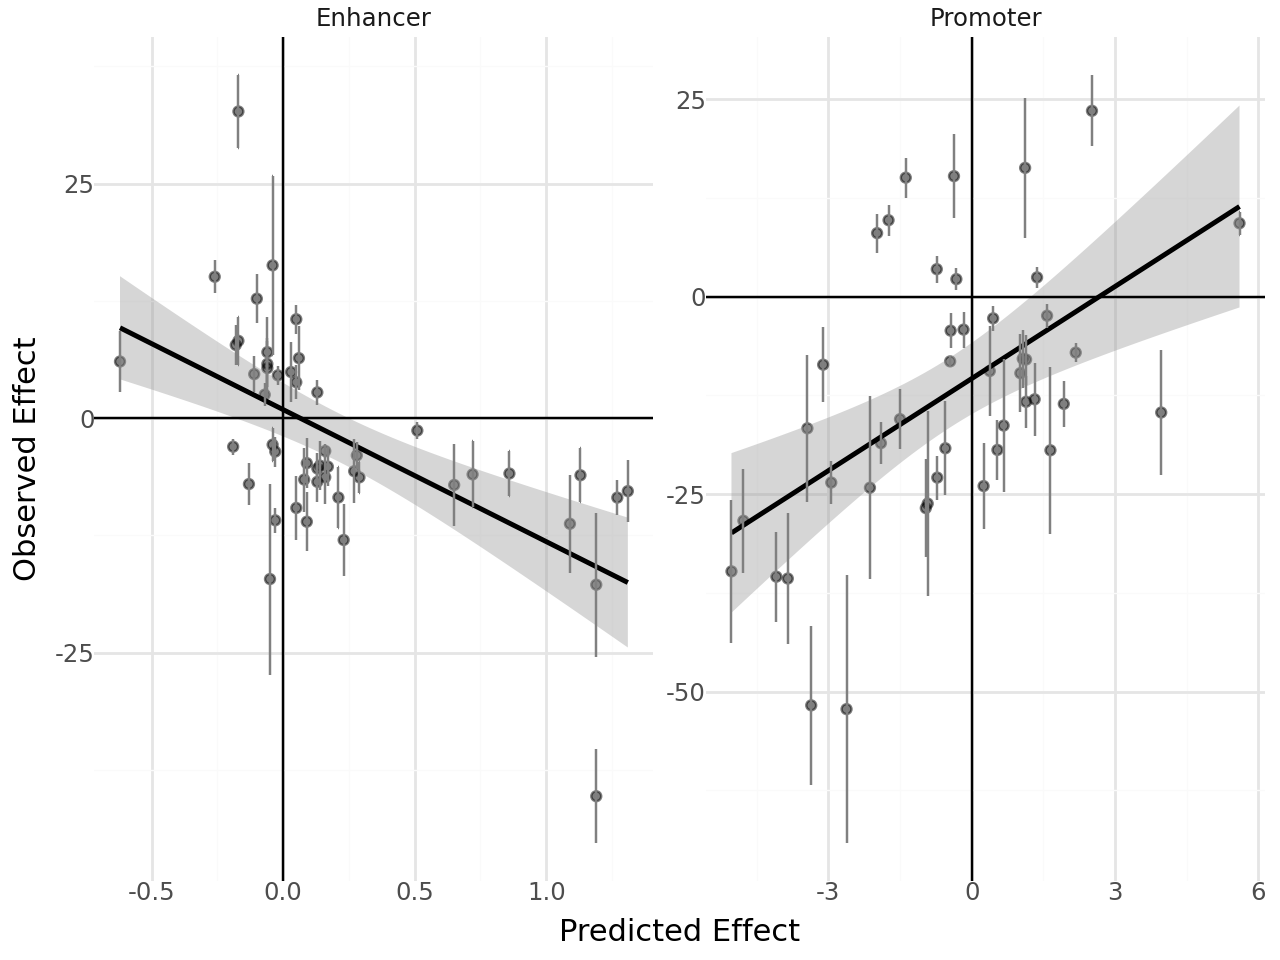

In [89]:
(p9.ggplot(varflowfish.loc[varflowfish['corrected p value'] < 0.05], 
           mapping=p9.aes(x='Enformer CAGE TSS',y='% change to PPIF expression')) 
 + p9.geom_point(alpha=0.5)
 + p9.geom_smooth(method='lm')
 #+ p9.scale_y_log10()
 #+ p9.scale_x_log10()
 + p9.geom_hline(yintercept=0)
 + p9.geom_vline(xintercept=0)
 + p9.geom_errorbar(mapping=p9.aes(ymin='minObs',ymax='maxObs'),width=0.001,color='grey')
 + p9.theme_minimal()
 + p9.labs(y='Observed Effect', x='Predicted Effect')
 + p9.facet_wrap('ElementType',scales='free')
)

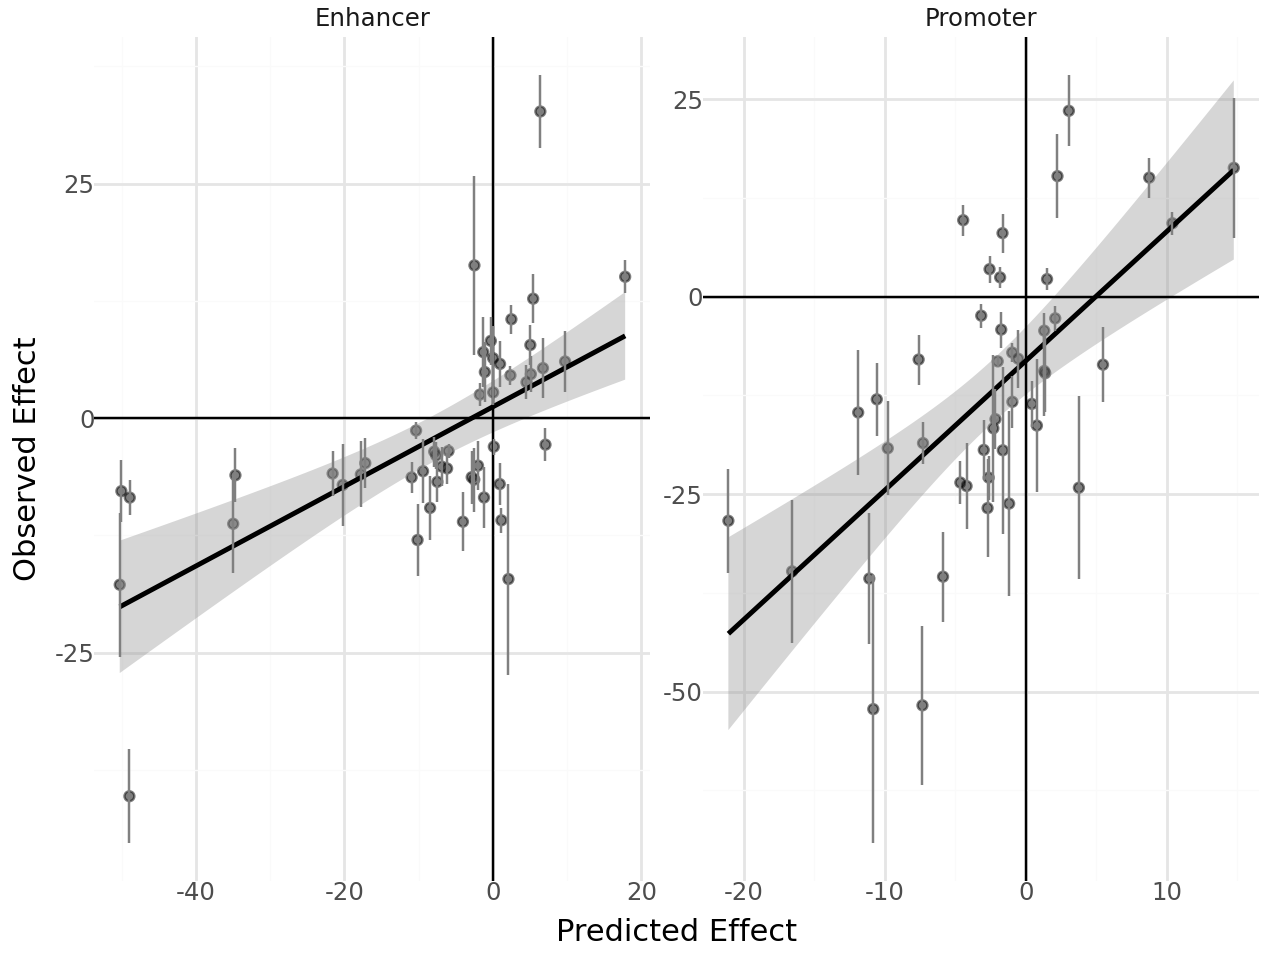

In [88]:
(p9.ggplot(varflowfish.loc[varflowfish['corrected p value'] < 0.05], 
           mapping=p9.aes(x='Enformer DNase',y='% change to PPIF expression')) 
 + p9.geom_point(alpha=0.5)
 + p9.geom_smooth(method='lm')
 #+ p9.scale_y_log10()
 #+ p9.scale_x_log10()
 + p9.geom_hline(yintercept=0)
 + p9.geom_vline(xintercept=0)
 + p9.geom_errorbar(mapping=p9.aes(ymin='minObs',ymax='maxObs'),width=0.001,color='grey')
 + p9.theme_minimal()
 + p9.labs(y='Observed Effect', x='Predicted Effect')
 + p9.facet_wrap('ElementType',scales='free')
)

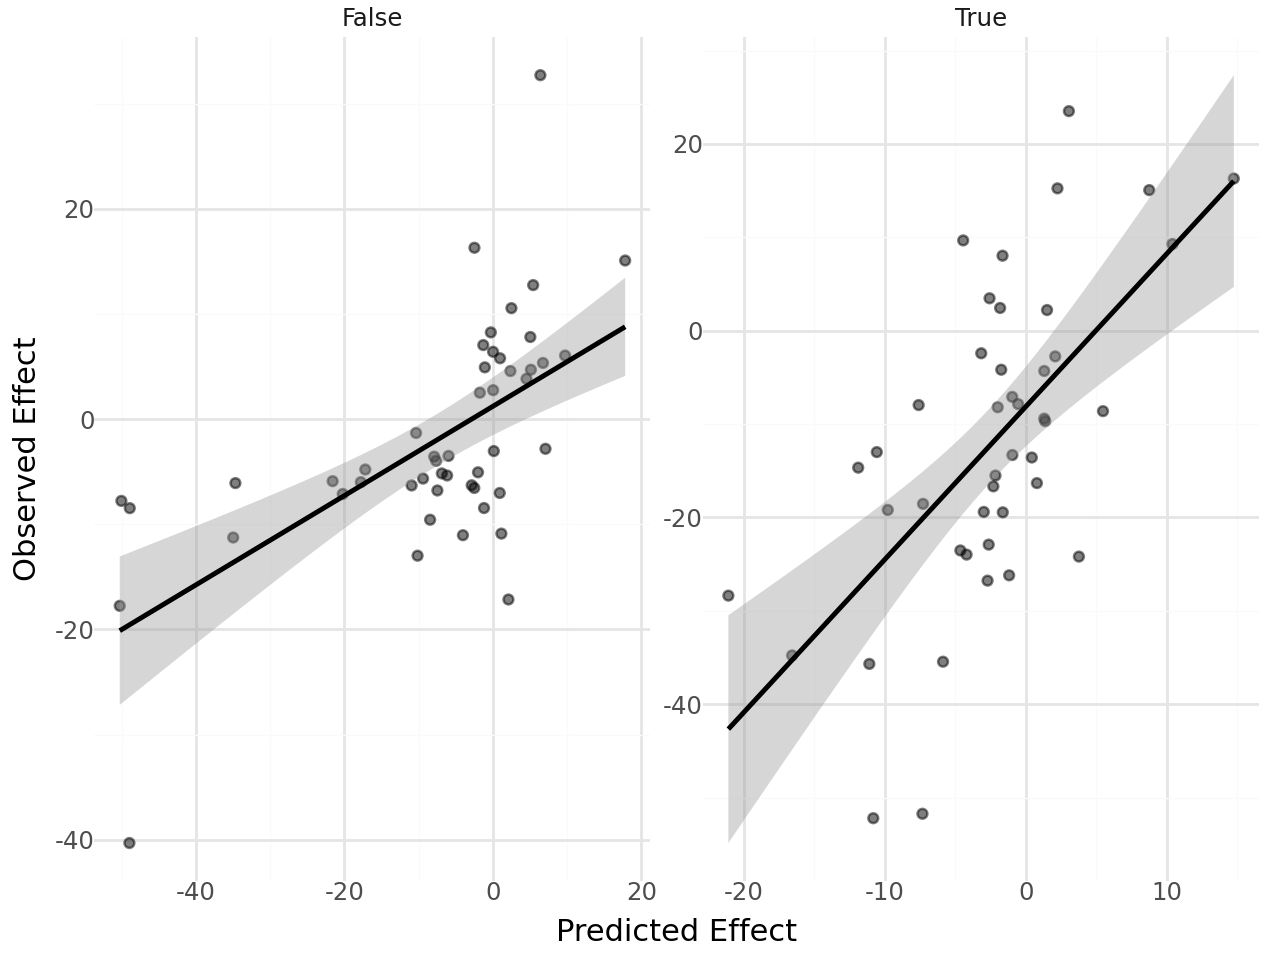

In [63]:
(p9.ggplot(varflowfish.loc[varflowfish['corrected p value'] < 0.05], 
           mapping=p9.aes(x='Enformer DNase',y='% change to PPIF expression')) 
 + p9.geom_point(alpha=0.5)
 + p9.geom_smooth(method='lm')
 #+ p9.scale_y_log10()
 #+ p9.scale_x_log10()
 + p9.geom_hline(yintercept=0)
 + p9.geom_vline(xintercept=0)
 + p9.geom_errorbar(mapping=p9.aes(ymin='minObs',ymax='maxObs'),width=0.001,color='grey')
 + p9.theme_minimal()
 + p9.labs(y='Observed Effect', x='Predicted Effect')
 + p9.facet_wrap('ElementType',scales='free')
)

In [71]:
rows = []
for subset in ['Promoter','not Promoter']:
    for model in ['borzoi_pred','Enformer CAGE TSS', 'Enformer DNase TSS ', 'Enformer CAGE', 'Enformer DNase','ChromBPNet ATAC']:
        sub_df = varflowfish.loc[varflowfish['corrected p value'] < 0.05].dropna(subset='% change to PPIF expression').query(f'{subset}')
        # if not model == 'Enformer CAGE TSS':
            # pearson = scipy.stats.pearsonr((np.exp(sub_df[model])) - 1,sub_df['% change to PPIF expression'])[0]
        #else:
        pearson = scipy.stats.pearsonr(sub_df[model],sub_df['% change to PPIF expression'])[0]
        spearman = scipy.stats.spearmanr(sub_df[model],sub_df['% change to PPIF expression'])[0]
        sign_concord = ((sub_df[model] > 0) == (sub_df['% change to PPIF expression'] > 0)).sum()/len(sub_df)
        rows.append({'model':model.replace('_pred',''),'subset':'Enhancer' if subset == 'not Promoter' else 'Promoter',
                     'sign_concord':sign_concord,
                     'pearson':pearson,'spearman':spearman,
                     'n':len(sub_df)})
corr_df = pd.DataFrame(rows)   

In [72]:
corr_df

,model,subset,sign_concord,pearson,spearman,n
0,borzoi,Promoter,0.545455,0.480326,0.372516,44
1,Enformer CAGE TSS,Promoter,0.522727,0.521286,0.509391,44
2,Enformer DNase TSS,Promoter,0.750000,0.647973,0.611980,44
3,Enformer CAGE,Promoter,0.477273,0.569700,0.538074,44
4,Enformer DNase,Promoter,0.727273,0.636760,0.606787,44
5,ChromBPNet ATAC,Promoter,0.613636,0.598577,0.527132,44
6,borzoi,Enhancer,0.775510,0.635299,0.657857,49
7,Enformer CAGE TSS,Enhancer,0.224490,-0.577060,-0.656526,49
8,Enformer DNase TSS,Enhancer,0.469388,0.061570,0.042634,49
9,Enformer CAGE,Enhancer,0.755102,0.694475,0.701429,49


In [35]:
corr_df

,model,subset,pearson,spearman,n
0,borzoi,Promoter,0.479171,0.372516,44
1,Enformer CAGE TSS,Promoter,0.521286,0.509391,44
2,Enformer DNase TSS,Promoter,0.261880,0.611980,44
3,Enformer CAGE,Promoter,0.212363,0.538074,44
4,Enformer DNase,Promoter,0.263005,0.606787,44
5,ChromBPNet ATAC,Promoter,0.150675,0.527132,44
6,borzoi,Enhancer,0.635390,0.657857,49
7,Enformer CAGE TSS,Enhancer,-0.577060,-0.656526,49
8,Enformer DNase TSS,Enhancer,0.048265,0.042634,49
9,Enformer CAGE,Enhancer,0.108649,0.701429,49


# sQTL

In [ ]:
sqtl_df_list =[]
for path in glob.glob('Data/sQTL/GTEx*.gz'):
    sqtl_df = pd.read_table(path, compression='gzip', comment = '#', names = ['Chromosome', 'Pos', 'variant', 'Ref', 'Alt','Garbo', 'Garbo2','Metadata'])
    sqtl_df['tissue_label'] = path.split('/')[-1].split('txrev_')[1].split('.')[0][:-4]
    sqtl_df['class'] = path.split('/')[-1].split('txrev_')[1].split('.')[0][-3:]
    sqtl_df_list.append(sqtl_df)
    # break
sqtl_df = pd.concat(sqtl_df_list)
sqtl_df['gene_id'] = sqtl_df['Metadata'].str.split('.').str[0].str.split('=').str[1]
sqtl_df['Start'] = sqtl_df['Pos'] - 1
sqtl_df['End'] = sqtl_df['Pos'] 

In [ ]:
mapping = pd.read_table('Data/gene_name_mapping.tsv')
mapping_dict = {r['gene_id']:r['gene_name'] for i,r in mapping.iterrows()}

In [ ]:
sqtl_df = sqtl_df.loc[sqtl_df['gene_id'].apply(lambda x: x in mapping_dict)] # remove the unnameable
sqtl_df['gene_name'] = sqtl_df['gene_id'].apply(lambda x: mapping_dict[x])
sqtl_df = sqtl_df.loc[~sqtl_df.gene_name.isin(['C2orf27A','GOLGA8M','LINC01238'])]# remove the ambiguously named

In [ ]:
sqtl_var_df = sqtl_df[['variant','Chromosome','Start','End','Ref','Alt','gene_id','gene_name']].drop_duplicates()

In [ ]:
#sqtl_var_df[['Chromosome','Start','End','Ref','Alt','gene_name','variant']].to_csv('Data/sQTL/vars.bed',sep="\t",index=None,header=None)
sqtl_var_df[['Chromosome','Start','End','Ref','Alt','gene_name','variant']].to_csv('Data/sQTL/vars.tsv',sep="\t",index=None)
sqtl_df.to_csv('Data/sQTL/all_vars.tsv',sep="\t", index=None)

## Write Config

In [ ]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_sqtl_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_sqtl_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/sQTL/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/sQTL/vars.tsv',
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep',
                  'prediction_bin_mode': 'transcriptome',
                  'track_subset': 'RNA',
                  'metric': 'normed_max_abs_diff',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

In [ ]:
configs = []
for model in ['borzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_sqtl_noautocast_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_sqtl_noautocast_{replicate}.txt',
                  'replicate': replicate,
                  'projectfolder': f'{base_path}/Results/sQTL/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiVariantCentred.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'data_path':f'{base_path}/Data/sQTL/vars.tsv',
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'squashed_scale_mode': 'keep',
                  'prediction_bin_mode': 'transcriptome',
                  'track_subset': 'RNA',
                  'metric': 'normed_max_abs_diff',
                  'return_center_bins_only': False,
                  'disable_autocast': True,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run

In [ ]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/borzoi_sqtl_0.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

In [ ]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p standard --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/borzoi_sqtl_noautocast_3.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

In [ ]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/flashzoi_sqtl_0.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

# CRISPRi

## Prepare table

In [ ]:
transcriptome = Transcriptome(gtf_file)

In [ ]:
df = pd.read_table(f'{base_path}/Data/CRISPRi/EPCrisprBenchmark_ensemble_data_GRCh38.tsv')
df['chromMid'] = (df['chromEnd'] + df['chromStart'])//2
df['dist'] = np.abs(df['chromMid'] - df['startTSS'])
# subset to borzoi size
df = df.query('dist < 261144')
df['startTSS'] = df['startTSS'].astype('int')
df['endTSS'] = df['endTSS'].astype('int')
# subset to known genes
known_names = [x for x in transcriptome.genes.keys()]
df = df.loc[df['measuredGeneSymbol'].isin(known_names)]

In [ ]:
df.to_csv(f'{base_path}/Data/CRISPRi/EPCrisprBenchmark_proximalsubset.tsv',index=None,sep="\t")

## Write config

### full bins

In [ ]:
configs = []
for model in ['borzoi','flashzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_crispr_allbins_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_crispr_allbins_{replicate}.txt',
                  'replicate': 0,
                  'projectfolder': f'{base_path}/Results/CRISPRi/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiCRISPRi.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'data_path': f'{base_path}/Data/CRISPRi/EPCrisprBenchmark_proximalsubset.tsv',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'return_center_bins_only': False,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

### Float32

In [ ]:
configs = []
for model in ['borzoi']:
    for replicate in range(4):
        config = {'name': f'{model}_crispr_allbins_noautocast_{replicate}',
                  'config_path': f'{base_path}/Pipe/Configs/{model}_crispr_allbins_noautocast_{replicate}.txt',
                  'replicate': 0,
                  'projectfolder': f'{base_path}/Results/CRISPRi/Chunky/',
                  'scripts_path': f'{base_path}/Pipe/Scripts/',
                  'script': 'BorzoiCRISPRi.py',
                  'num_of_jobs': 10,
                  'conda': 'scooby_package',
                  'data_path': f'{base_path}/Data/CRISPRi/EPCrisprBenchmark_proximalsubset.tsv',
                  'targets_path': targets_path,
                  'gtf_file': gtf_file,
                  'fasta_file': fasta_file,
                  'pretrained_path': f'johahi/{model}-replicate-{replicate}',
                  'file_suffix': 'h5ad',
                  'return_center_bins_only': False,
                  'disable_autocast': True,
                 }
        configs.append(config)
        with open(config['config_path'], 'w') as outfile:
            yaml.dump(config, outfile)

## Run

In [ ]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/borzoi_crispr_allbins_noautocast_3.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/

In [ ]:
!sbatch -c 4 --mem 10G --error job_reports/job.%J.err --output job_reports/job.%J.out -J brozoi -p urgent --requeue Pipe/chunk_call.sh \
/s/project/multispecies/Modelling/Snoopy/Pipe/Configs/flashzoi_crispr_allbins_3.txt \
doing_stuff_in_the_arena \
/s/project/multispecies/Modelling/Snoopy/Pipe/job_reports/